Download the package

In [ ]:
!git clone https://github.com/Gr1Lo/direct.git

Cloning into 'direct'...
remote: Enumerating objects: 213, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 213 (delta 31), reused 0 (delta 0), pack-reused 156
Receiving objects: 100% (213/213), 2.37 MiB | 5.62 MiB/s, done.
Resolving deltas: 100% (83/83), done.


Import functions

In [ ]:
import sys
sys.path.insert(0,'/content/direct/scripts')
from utils import find_nearest, CE, RE, direct_statistics
from plots import plot3d, plot2d, plot_clim_train_test
from read_data import rwl2pandas, read_meteo, direct_read, standardize_train, standardize_test, train_test_split
from direct_surface import sq_method, make_surface, predict_on_surface, leave_k_out_plot

# Synthetic dataset generation

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle

#noise generators
def noise_psd(N, psd = lambda f: 1):
        X_white = np.fft.rfft(np.random.randn(N));
        S = psd(np.fft.rfftfreq(N))
        # Normalize S
        S = S / np.sqrt(np.mean(S**2))
        X_shaped = X_white * S;
        return np.fft.irfft(X_shaped);

def PSDGenerator(f):
    return lambda N: noise_psd(N, f)

@PSDGenerator
def brownian_noise(f):
    return 1/np.where(f == 0, float('inf'), f)

@PSDGenerator
def white_noise(f):
    return 1;

#1000-years climate series
Fs = 1000
f = 1.5
sample = 1000
t = np.arange(sample)
y = -2 * np.cos(2 * np.pi * f * t / Fs) + brownian_noise(sample) + white_noise(sample)

years = np.arange(1,1001)
ser = pd.Series(data=y, index=years)
#p = plt.plot(y)

#with open('/content/direct/synthetic_dataset/ser.pickle', 'wb') as handle:
#    pickle.dump(ser, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/direct/synthetic_dataset/ser.pickle', 'rb') as handle:
    ser = pickle.load(handle)

Trees generator

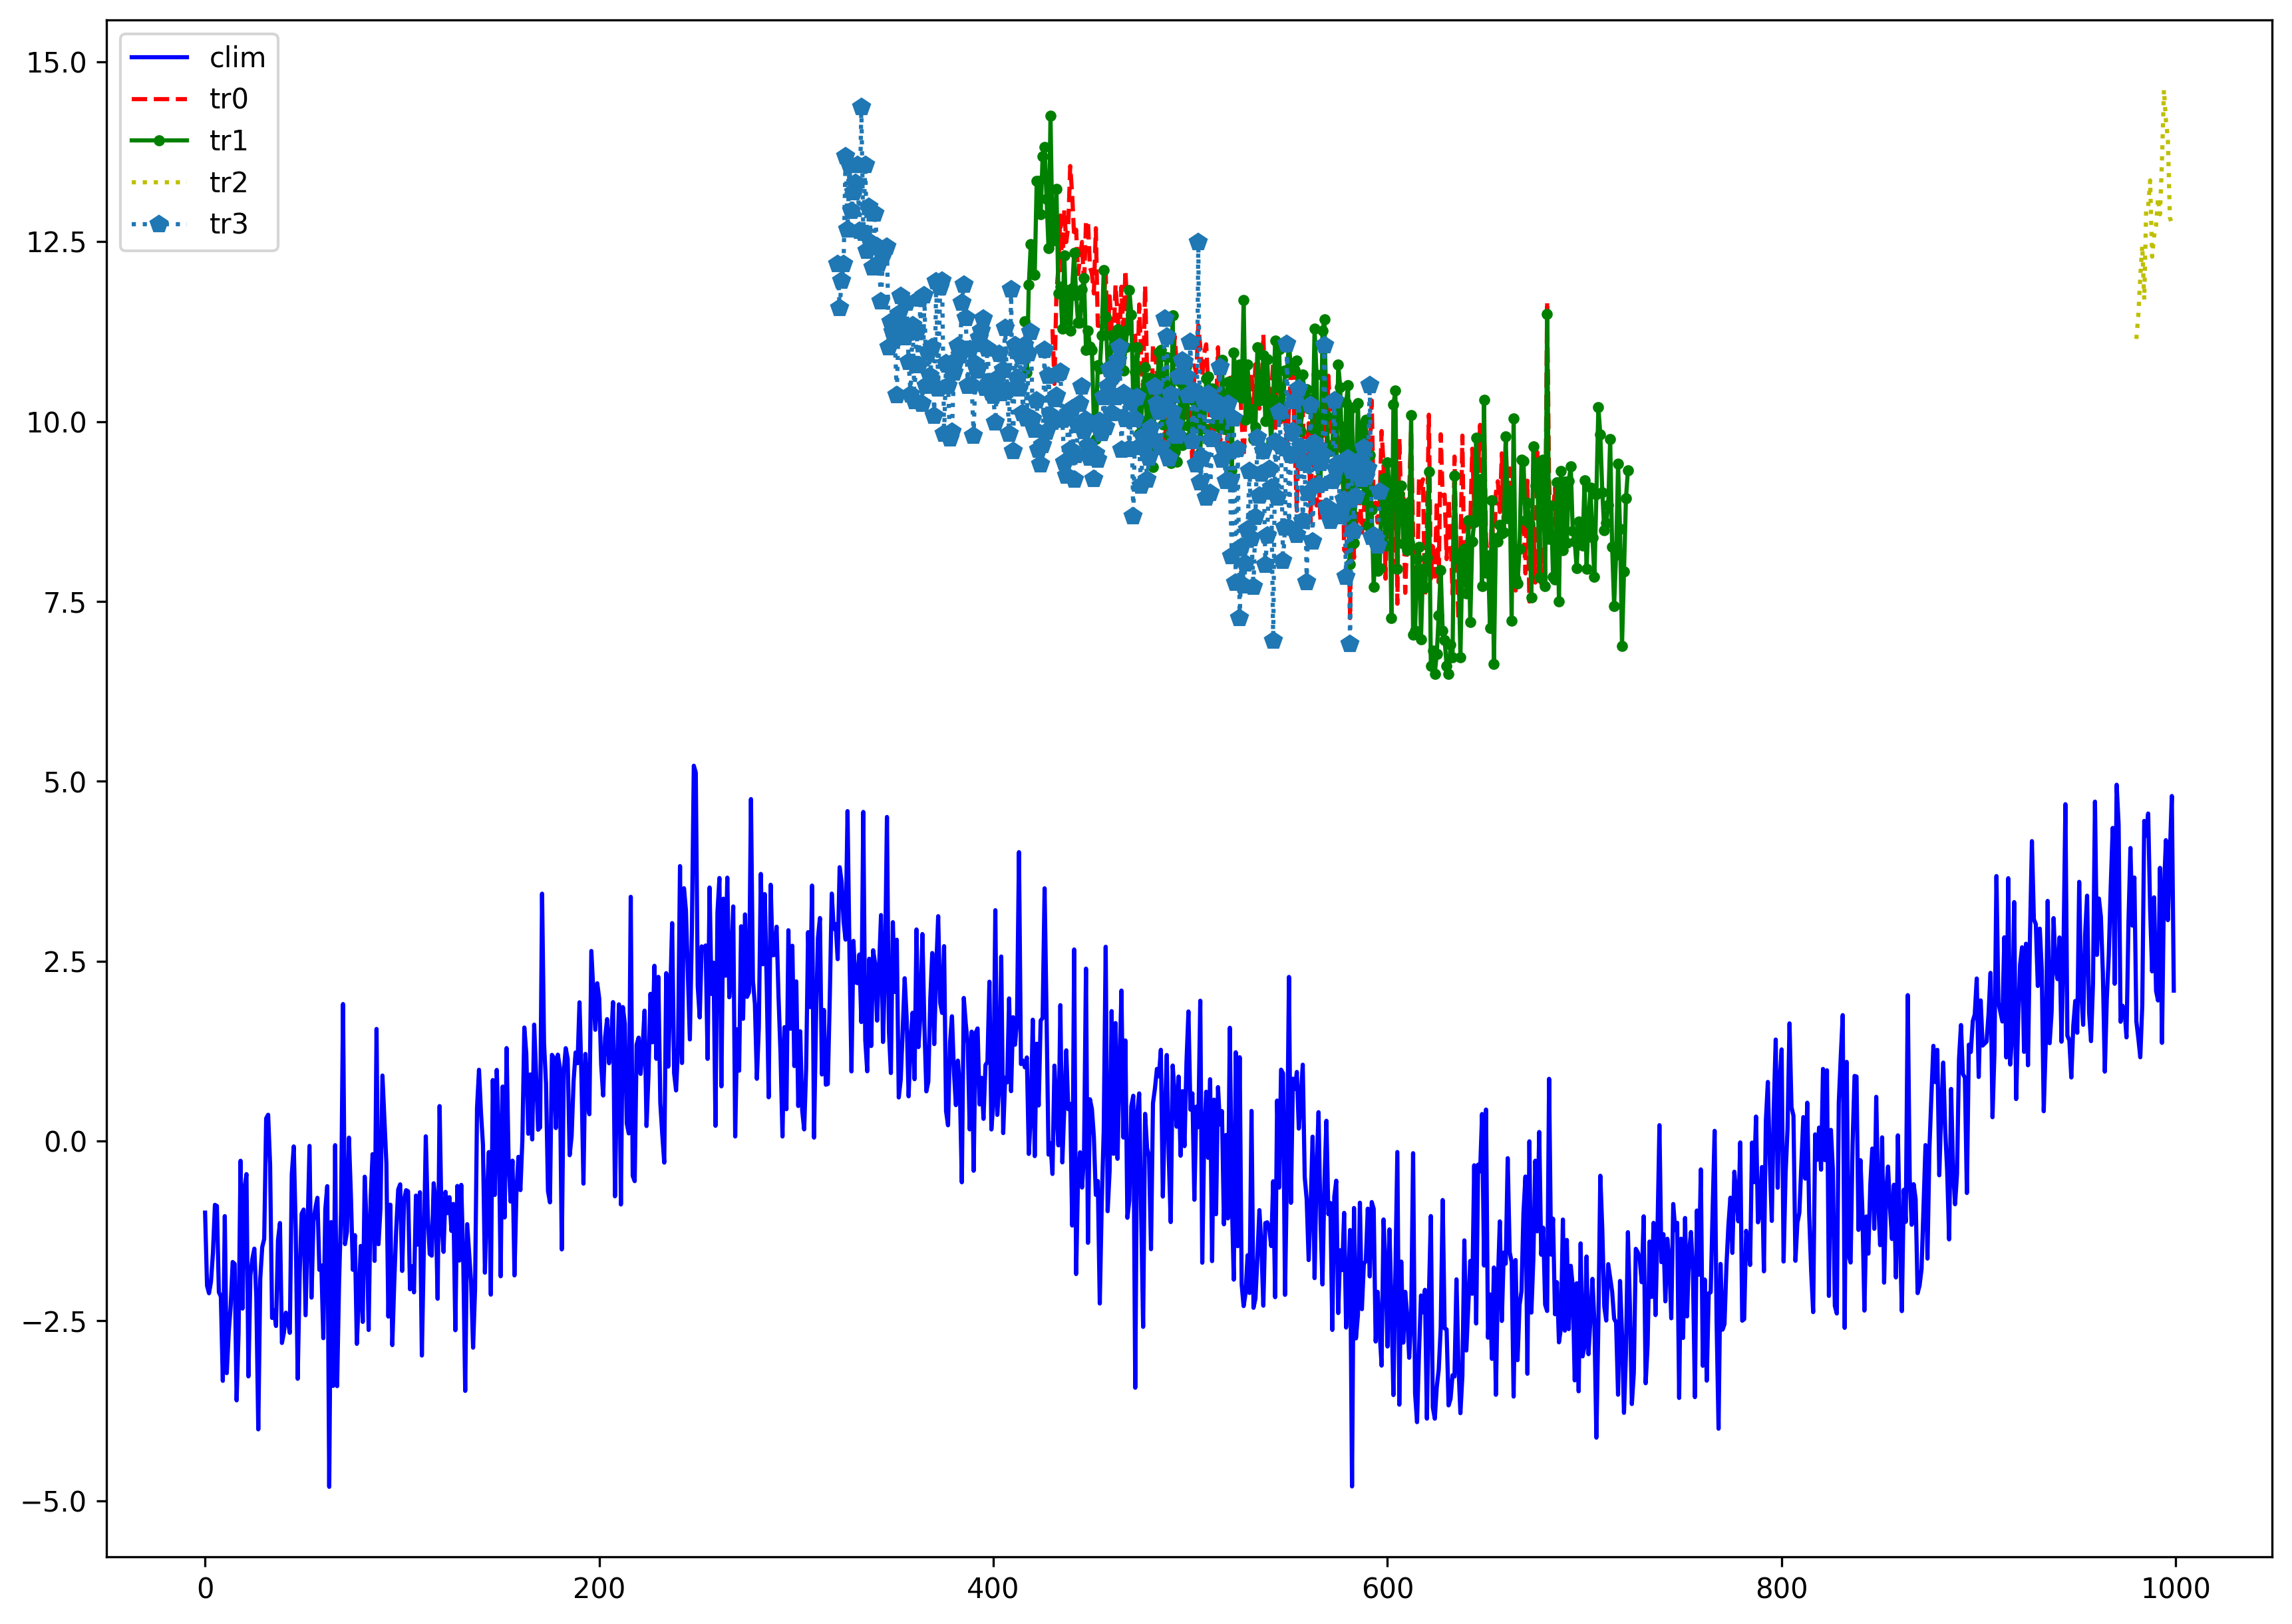

In [ ]:
def generate_trees(clim_series, n, mean_age, std_age,
                   hugershoff_a = 0.3, hugershoff_b = 1,
                   hugershoff_c = 0.1, hugershoff_d = 0.1,
                   clim_coef = 0.1, noise_coef=0.1):

    df = clim_series.to_frame()
    df = df.reset_index()
    df = df.rename(columns={"index": "years", 0: "clim"})

    ages_max = np.int32(np.random.normal(mean_age, std_age, n))
    start_years = np.int32(np.random.uniform(min(clim_series.index),len(clim_series),n))
    for tr in range(len(ages_max)):
          t_ages_max = ages_max[tr]
          if t_ages_max+start_years[tr]>len(clim_series):
              t_ages_max = len(clim_series)-start_years[tr]

          ages = np.arange(1, t_ages_max+1)
          t = np.arange(start_years[tr],start_years[tr]+t_ages_max)
          hugershoff = (hugershoff_a *
                        (ages**hugershoff_b) *
                        np.exp(-hugershoff_c*ages) +
                        hugershoff_d)
          bn = brownian_noise(len(ages)+1) + 1*white_noise(len(ages)+1)
          hugershoff_p_red = hugershoff + noise_coef * bn[:len(hugershoff)]
          exp_var0 = int(mean_age/2)

          exp_var1 = np.random.uniform(0.01, 0.2, 1)[0]
          sigmoid = clim_coef*(0.+(1 / (1 + np.exp(np.float128(-exp_var1*(ages-exp_var0))))))
          if clim_coef==0:
            clim_response = 1*clim_series.values[t]
          else:
            clim_response = np.multiply(clim_series.values[t],sigmoid+0.1)

          hugershoff_p_red_p_clim = hugershoff_p_red + clim_response + 10
          tdf = pd.DataFrame({'years': t,
                              'tr'+str(tr) :hugershoff_p_red_p_clim})

          df = pd.merge(df, tdf, on="years",how='left')

    return df


trdf = generate_trees(ser,
                      n=100,
                      mean_age=300,
                      std_age=50,
                      hugershoff_a = 0.8,
                      hugershoff_b = 1,
                      hugershoff_c = 0.1,
                      hugershoff_d = 0.1,
                      clim_coef = 0.5,
                      noise_coef=0.5)


styles = ['b-','r--','g.-','y:','p:']

trdf.plot(y=['clim']+list(trdf.columns[2:6].values), use_index=True, style=styles,
          figsize=(14,10))


#convert trees to rwl and pth-file
def pandas2rwl(df, rwl_path, pth_path):
    if os.path.exists(pth_path):
        os.remove(pth_path)

    with open(pth_path, 'w',encoding='utf-8') as fpth:
      str_pth = 'series pith.offset\n'
      fpth.write(str_pth)

    if os.path.exists(rwl_path):
        os.remove(rwl_path)
    df = df.sort_values(by=['years'])
    with open(rwl_path, 'w',encoding='utf-8') as f:
      l = list(df.columns.values)
      l.remove('years')
      l.remove('clim')
      for col in l:
          dft = df[["years", col]]
          dft = dft[~dft[col].isnull()]
          str_l = " " * 100
          cou = 0
          val_ind = 18
          for index, row in dft.iterrows():
              val = str((row[col]*100).astype(int))
              year_str = str(int(row['years']))
              if row['years'].astype(int)%10 == 0 or cou==0:
                  if str_l != " " * 100:
                      str_l = str_l.rstrip()+ '\n'
                      f.write(str_l)
                      val_ind = 18
                      str_l = " " * 100

                  str_l = (col + str_l[len(col):])

                  ind0 = 12-len(year_str)
                  str_l = (str_l[:ind0] +
                              year_str +
                              str_l[12:])

                  ind1 = val_ind-len(val)
                  str_l = (str_l[:ind1] +
                              val +
                              str_l[val_ind:])

                  val_ind += 6


              else:
                  ind1 = val_ind-len(val)
                  str_l = (str_l[:ind1] +
                              val +
                              str_l[val_ind:])
                  val_ind += 6

              cou += 1

          val = '-9999'
          year_str = str(int(year_str)+1)
          if int(year_str)%10 == 0 or cou==0:
            str_l = str_l.rstrip()+ '\n'
            f.write(str_l)
            val_ind = 18
            str_l = " " * 100

            str_l = (col + str_l[len(col):])
            ind0 = 12-len(year_str)
            str_l = (str_l[:ind0] + year_str + str_l[12:])
            ind1 = val_ind-len(val)
            str_l = (str_l[:ind1] + val + str_l[val_ind:])
            val_ind += 6
          else:
            ind1 = val_ind-len(val)
            str_l = (str_l[:ind1] + val + str_l[val_ind:])
            val_ind += 6

          str_l = str_l.rstrip()+ '\n'
          f.write(str_l)

          with open(pth_path, 'a',encoding='utf-8') as fpth:
                str_pth = col + ' 1\n'
                fpth.write(str_pth)



#with open('/content/direct/synthetic_dataset/trdf.pickle', 'wb') as handle:
#    pickle.dump(trdf, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/direct/synthetic_dataset/trdf.pickle', 'rb') as handle:
    trdf = pickle.load(handle)

trdf[['years','clim']].to_csv('/content/direct/synthetic_dataset/clim.csv',
                              index=False,header=False,sep='\t')
pandas2rwl(trdf, '/content/direct/synthetic_dataset/synthetic_ds.rwl',
           '/content/direct/synthetic_dataset/synthetic_ds.pth')

Data preparation

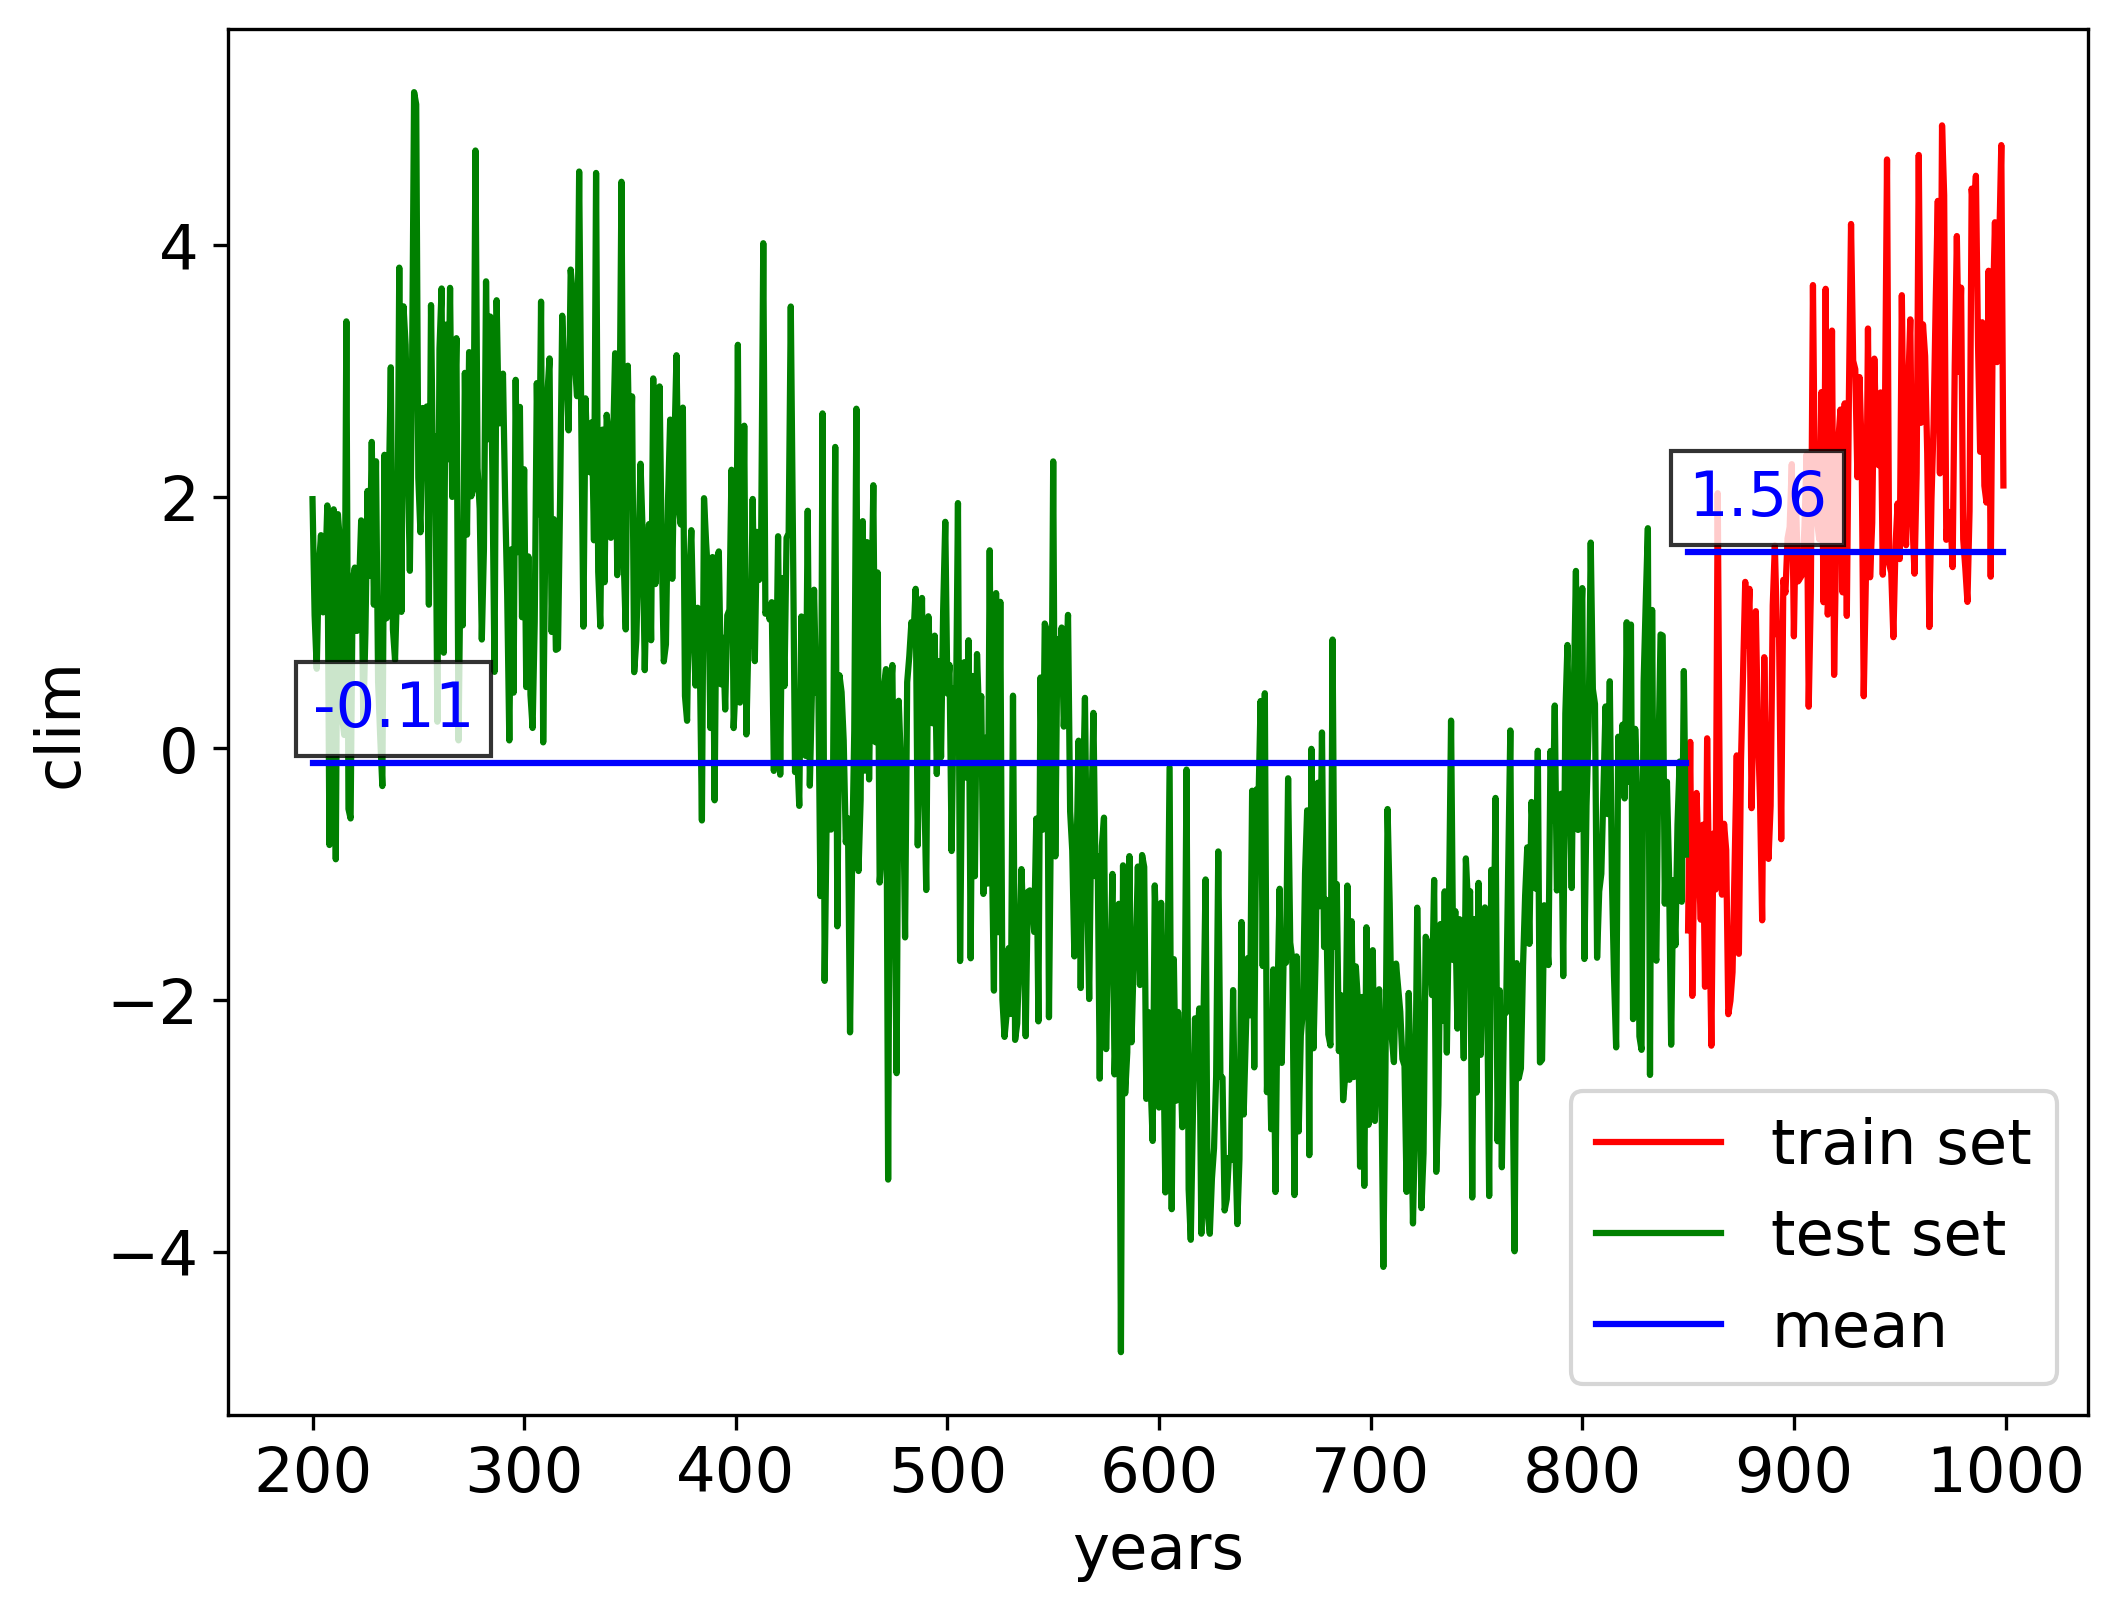

In [ ]:
import warnings
warnings.filterwarnings('ignore')

proxy_name = 'proxy'
clim_name = 'clim'

#reading meteo and proxy data into single dataframe
mres = direct_read('/content/direct/synthetic_dataset/synthetic_ds.rwl',
              '/content/direct/synthetic_dataset/clim.csv',
              proxy_name = proxy_name,
              clim_name = clim_name,
              pth_path = '/content/direct/synthetic_dataset/synthetic_ds.pth',
              meteo_months=[1])
mres = mres.sort_values(by=['years'])
ys=np.arange(min(mres.years),max(mres.years)+1)

#select years before 850 as test sample, others leaved to train dataset
mask = ~(ys>=850)

#read rcs and rcs-sf chronologies
rwis = pd.read_csv('/content/direct/synthetic_dataset/rwis.csv')
mres = mres.merge(rwis, left_on='years', right_on='years', how='left')

train, test, train_dict = train_test_split(mres, proxy_name, clim_name,
                                           years_mask=mask,
                                           train_age_std_coef=1)

#select from test dataset years after 200
test = test[test.years>=200]
plot_clim_train_test(train, test, clim_var=clim_name)

Find best parameters for surface (kernel='linear', Z_shift=True)

  0%|          | 0/6 [00:00<?, ?it/s]

smooth: 0.5



  0%|          | 0/6 [00:00<?, ?it/s]

n squares: 10



 17%|█▋        | 1/6 [01:04<05:23, 64.64s/it]

n squares: 20



 33%|███▎      | 2/6 [02:46<05:46, 86.63s/it]

n squares: 30



 50%|█████     | 3/6 [05:27<06:00, 120.29s/it]

n squares: 40



 67%|██████▋   | 4/6 [09:29<05:37, 168.54s/it]

n squares: 50



 83%|████████▎ | 5/6 [15:12<03:51, 231.28s/it]

n squares: 60



 17%|█▋        | 1/6 [22:55<1:54:36, 1375.23s/it]

smooth: 1



  0%|          | 0/6 [00:00<?, ?it/s]

n squares: 10



 17%|█▋        | 1/6 [01:04<05:24, 64.83s/it]

n squares: 20



 33%|███▎      | 2/6 [02:46<05:44, 86.21s/it]

n squares: 30



 50%|█████     | 3/6 [05:26<05:59, 119.98s/it]

n squares: 40



 67%|██████▋   | 4/6 [09:28<05:36, 168.11s/it]

n squares: 50



 83%|████████▎ | 5/6 [15:12<03:51, 231.64s/it]

n squares: 60



 33%|███▎      | 2/6 [45:50<1:31:41, 1375.41s/it]

smooth: 3



  0%|          | 0/6 [00:00<?, ?it/s]

n squares: 10



 17%|█▋        | 1/6 [01:04<05:24, 64.92s/it]

n squares: 20



 33%|███▎      | 2/6 [02:45<05:44, 86.19s/it]

n squares: 30



 50%|█████     | 3/6 [05:25<05:59, 119.69s/it]

n squares: 40



 67%|██████▋   | 4/6 [09:28<05:36, 168.26s/it]

n squares: 50



 83%|████████▎ | 5/6 [15:10<03:50, 230.89s/it]

n squares: 60



 50%|█████     | 3/6 [1:08:47<1:08:47, 1375.86s/it]

smooth: 5



  0%|          | 0/6 [00:00<?, ?it/s]

n squares: 10



 17%|█▋        | 1/6 [01:04<05:24, 64.83s/it]

n squares: 20



 33%|███▎      | 2/6 [02:45<05:43, 85.84s/it]

n squares: 30



 50%|█████     | 3/6 [05:27<06:01, 120.60s/it]

n squares: 40



 67%|██████▋   | 4/6 [09:32<05:39, 169.74s/it]

n squares: 50



 83%|████████▎ | 5/6 [15:16<03:52, 232.49s/it]

n squares: 60



 67%|██████▋   | 4/6 [1:31:47<45:55, 1377.81s/it]  

smooth: 10



  0%|          | 0/6 [00:00<?, ?it/s]

n squares: 10



 17%|█▋        | 1/6 [01:05<05:25, 65.09s/it]

n squares: 20



 33%|███▎      | 2/6 [02:46<05:46, 86.71s/it]

n squares: 30



 50%|█████     | 3/6 [05:27<06:01, 120.33s/it]

n squares: 40



 67%|██████▋   | 4/6 [09:25<05:34, 167.04s/it]

n squares: 50



 83%|████████▎ | 5/6 [15:07<03:50, 230.14s/it]

n squares: 60



 83%|████████▎ | 5/6 [1:54:44<22:57, 1377.34s/it]

smooth: 15



  0%|          | 0/6 [00:00<?, ?it/s]

n squares: 10



 17%|█▋        | 1/6 [01:06<05:34, 66.91s/it]

n squares: 20



 33%|███▎      | 2/6 [02:47<05:46, 86.73s/it]

n squares: 30



 50%|█████     | 3/6 [05:25<05:58, 119.40s/it]

n squares: 40



 67%|██████▋   | 4/6 [09:26<05:34, 167.21s/it]

n squares: 50



 83%|████████▎ | 5/6 [15:03<03:48, 228.68s/it]

n squares: 60



100%|██████████| 6/6 [2:17:26<00:00, 1374.48s/it]


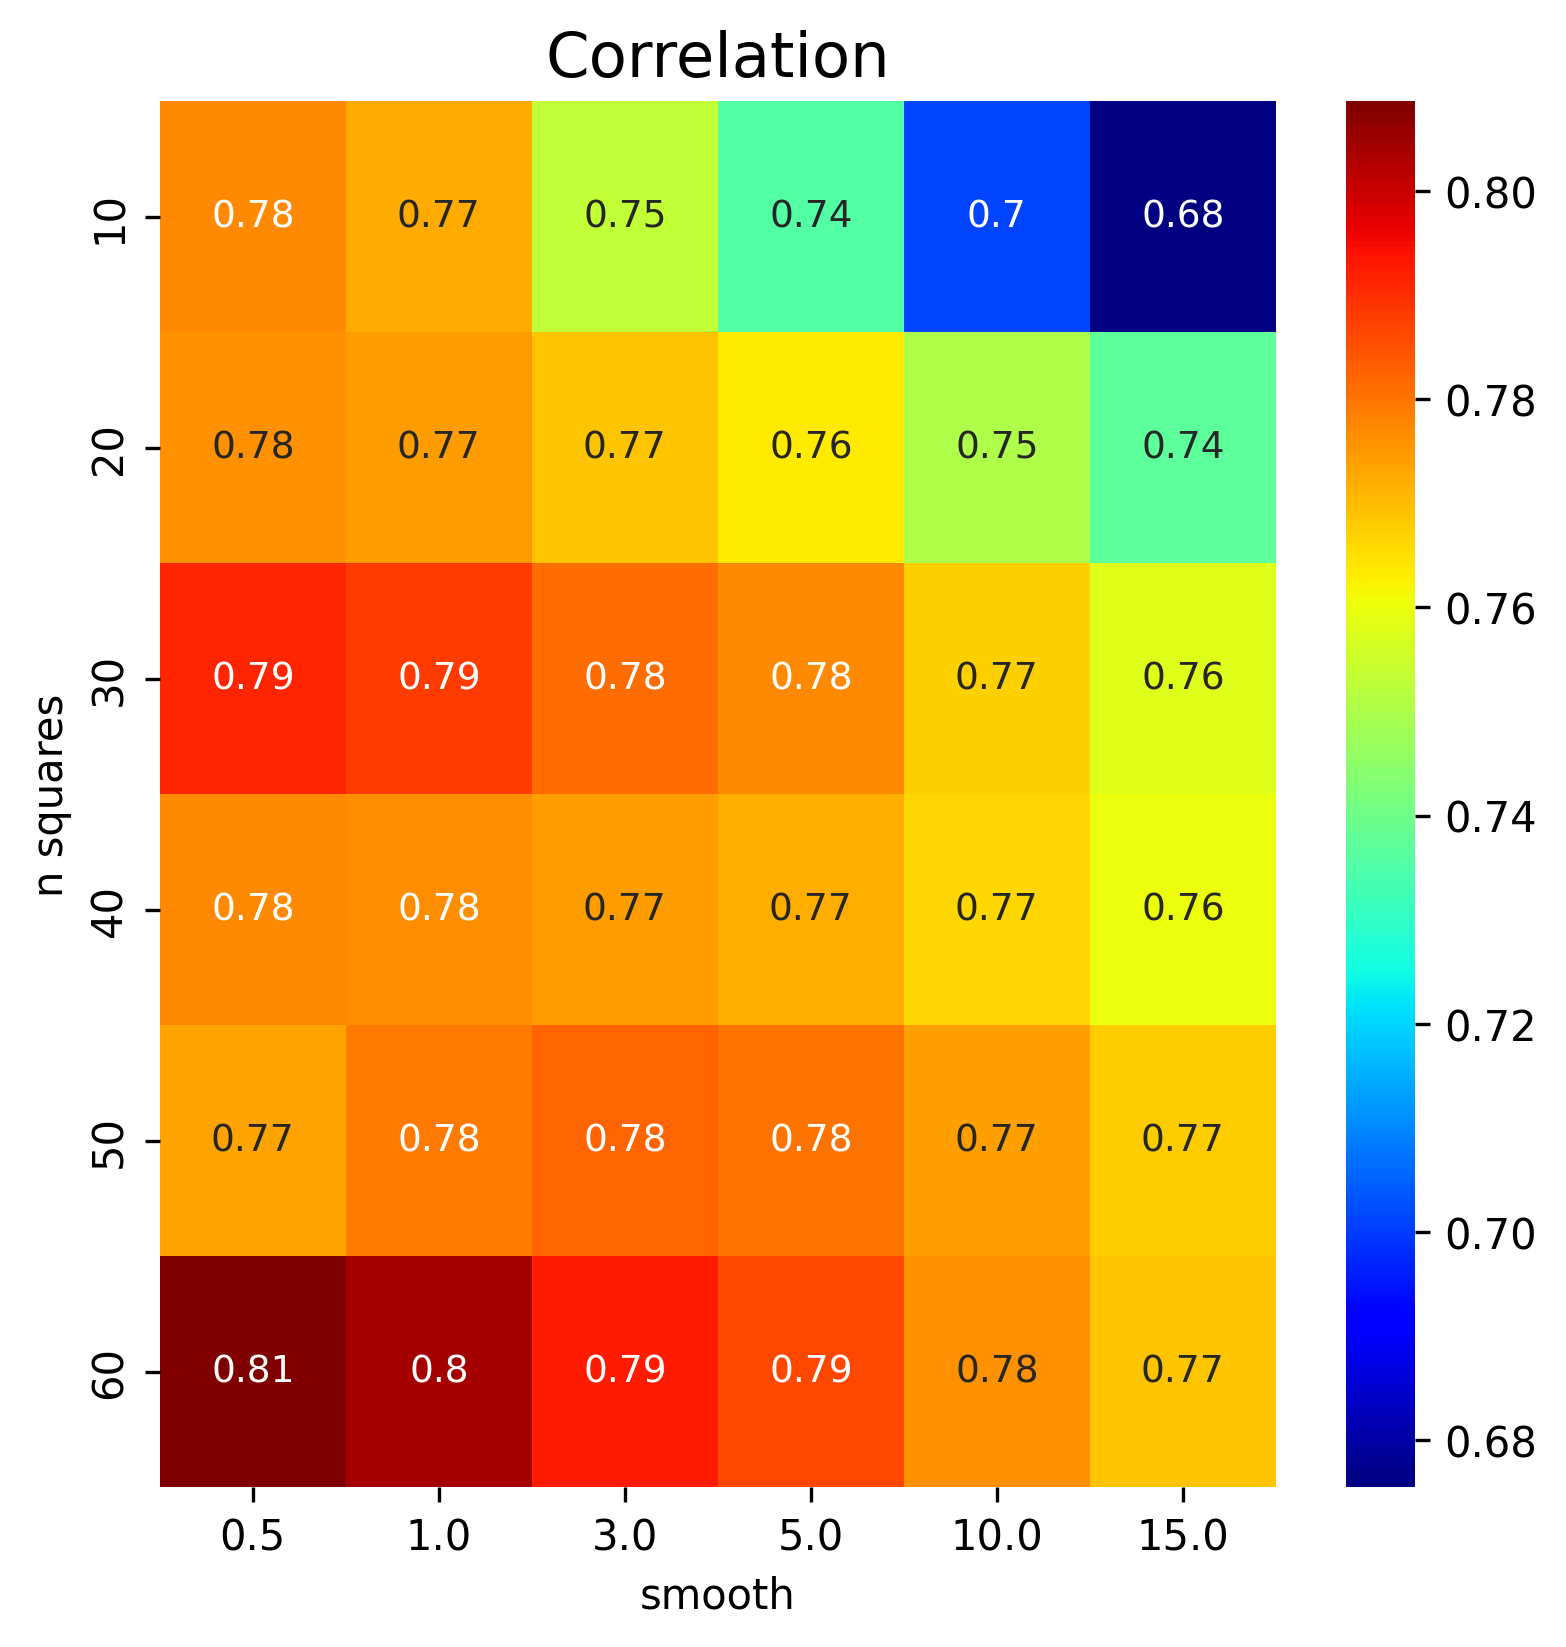

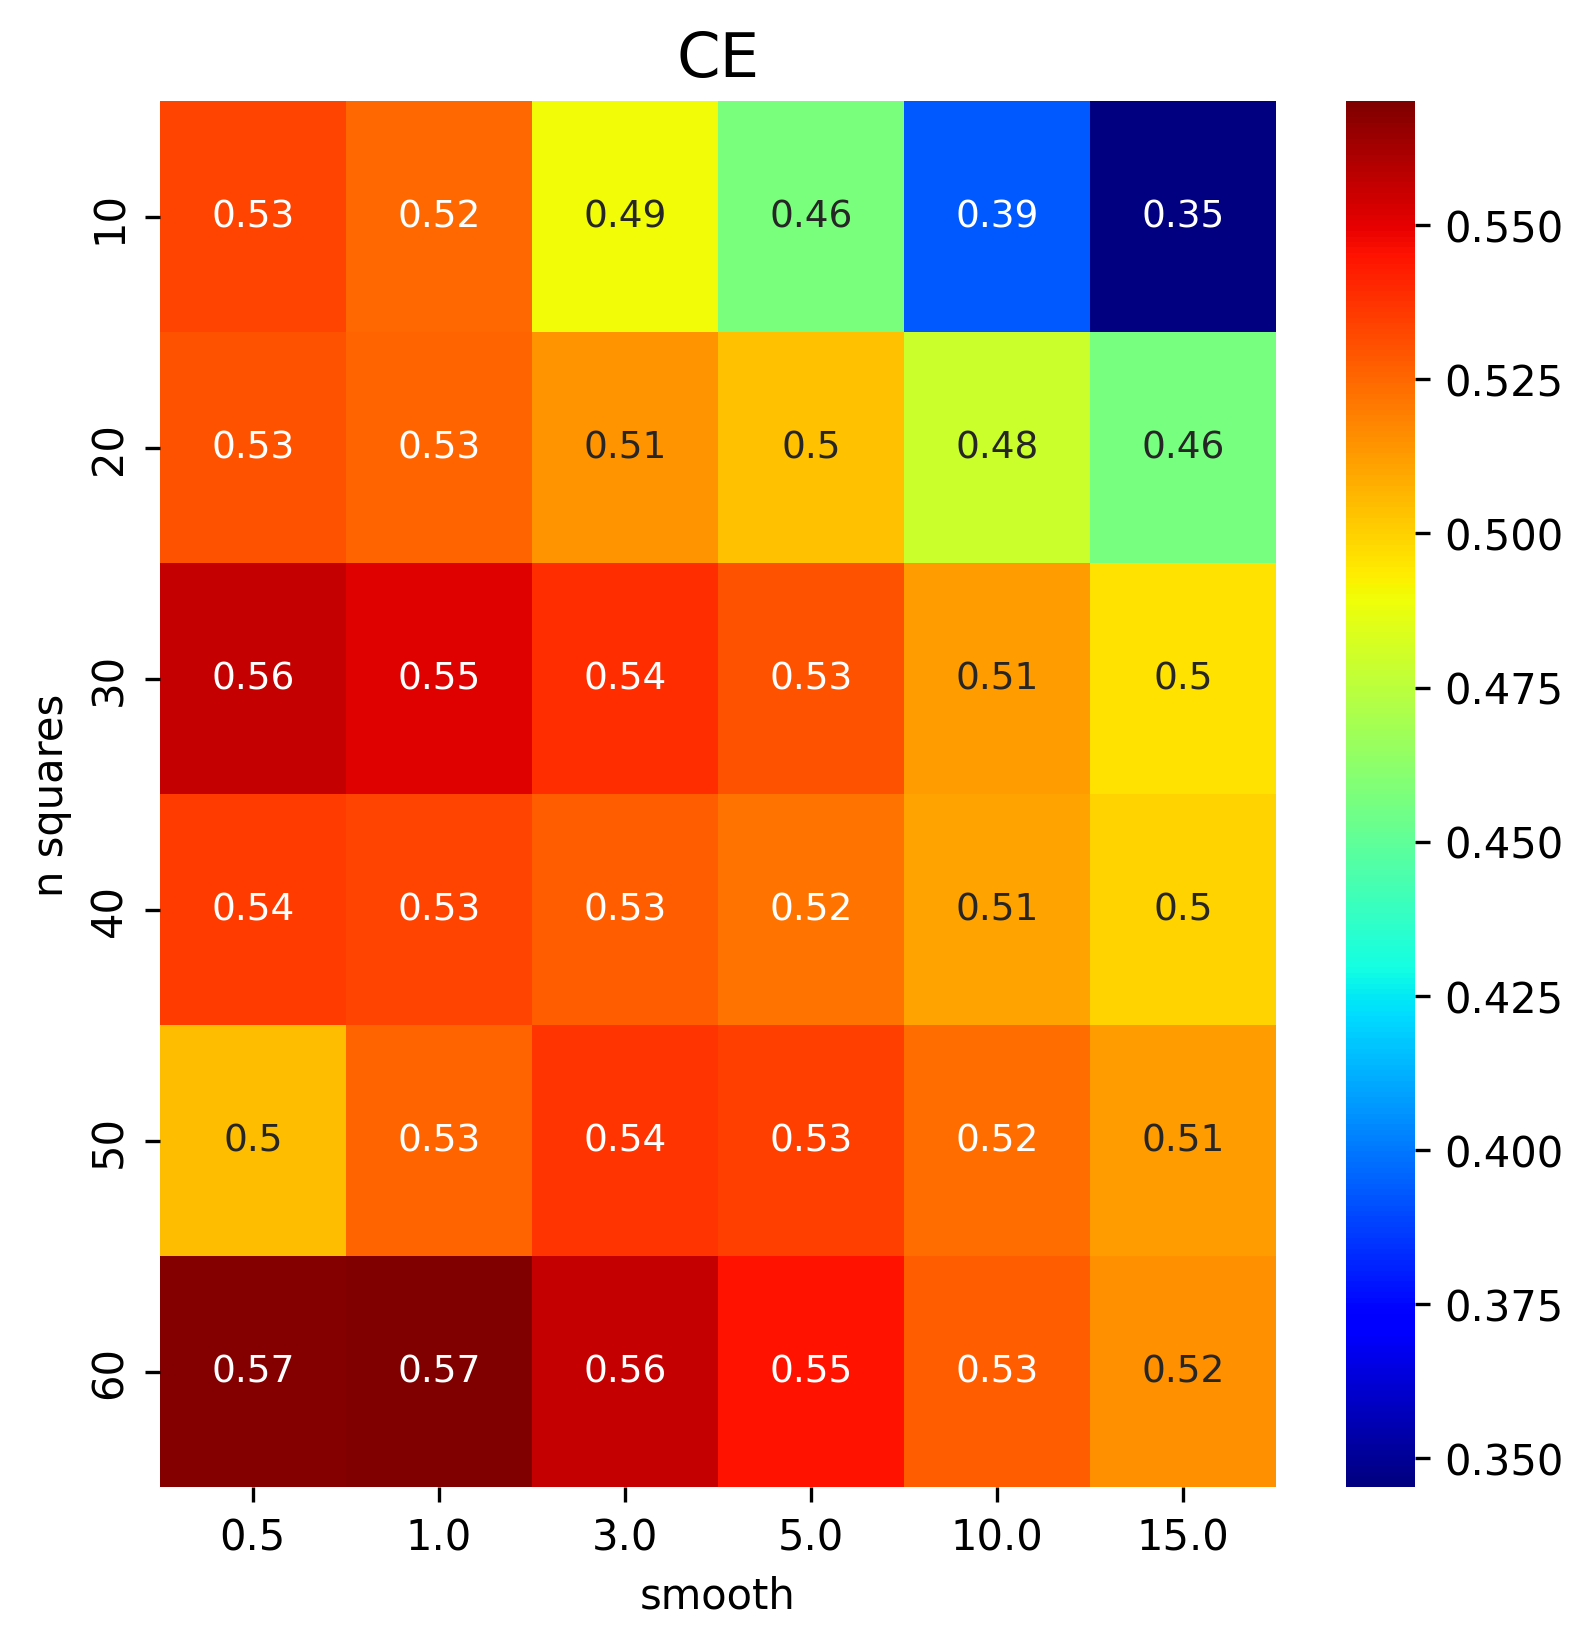

In [ ]:
tests_lko = leave_k_out_plot(train, clim_name, proxy_name,
                     k=20, n=100,
                     n_sq=[10,20,30,40,50,60], sm=[0.5,1,3,5,10,15],
                     kernel='linear', use_std = True, use_squares=True, Z_shift=True)



  0%|          | 0/6 [00:00<?, ?it/s]

smooth: 0.5



  0%|          | 0/6 [00:00<?, ?it/s]

n squares: 10



 17%|█▋        | 1/6 [01:06<05:34, 66.91s/it]

n squares: 20



 33%|███▎      | 2/6 [02:56<06:07, 91.77s/it]

n squares: 30



 50%|█████     | 3/6 [05:51<06:29, 129.93s/it]

n squares: 40



 67%|██████▋   | 4/6 [10:18<06:07, 183.88s/it]

n squares: 50



 83%|████████▎ | 5/6 [16:37<04:14, 254.45s/it]

n squares: 60



 17%|█▋        | 1/6 [25:08<2:05:43, 1508.65s/it]

smooth: 1



  0%|          | 0/6 [00:00<?, ?it/s]

n squares: 10



 17%|█▋        | 1/6 [01:07<05:38, 67.75s/it]

n squares: 20



 33%|███▎      | 2/6 [02:58<06:12, 93.11s/it]

n squares: 30



 50%|█████     | 3/6 [05:54<06:33, 131.05s/it]

n squares: 40



 67%|██████▋   | 4/6 [10:25<06:12, 186.08s/it]

n squares: 50



 83%|████████▎ | 5/6 [16:45<04:16, 256.17s/it]

n squares: 60



 33%|███▎      | 2/6 [50:27<1:40:57, 1514.44s/it]

smooth: 3



  0%|          | 0/6 [00:00<?, ?it/s]

n squares: 10



 17%|█▋        | 1/6 [01:06<05:32, 66.46s/it]

n squares: 20



 33%|███▎      | 2/6 [02:56<06:08, 92.04s/it]

n squares: 30



 50%|█████     | 3/6 [05:52<06:31, 130.56s/it]

n squares: 40



 67%|██████▋   | 4/6 [10:23<06:11, 185.70s/it]

n squares: 50



 83%|████████▎ | 5/6 [16:43<04:15, 255.92s/it]

n squares: 60



 50%|█████     | 3/6 [1:15:43<1:15:45, 1515.33s/it]

smooth: 5



  0%|          | 0/6 [00:00<?, ?it/s]

n squares: 10



 17%|█▋        | 1/6 [01:06<05:31, 66.37s/it]

n squares: 20



 33%|███▎      | 2/6 [02:55<06:05, 91.42s/it]

n squares: 30



 50%|█████     | 3/6 [05:50<06:29, 129.85s/it]

n squares: 40



 67%|██████▋   | 4/6 [10:20<06:10, 185.07s/it]

n squares: 50



 83%|████████▎ | 5/6 [16:45<04:17, 257.30s/it]

n squares: 60



 67%|██████▋   | 4/6 [1:41:07<50:37, 1518.83s/it]  

smooth: 10



  0%|          | 0/6 [00:00<?, ?it/s]

n squares: 10



 17%|█▋        | 1/6 [01:05<05:28, 65.67s/it]

n squares: 20



 33%|███▎      | 2/6 [02:57<06:10, 92.71s/it]

n squares: 30



 50%|█████     | 3/6 [05:56<06:36, 132.08s/it]

n squares: 40



 67%|██████▋   | 4/6 [10:25<06:12, 186.26s/it]

n squares: 50



 83%|████████▎ | 5/6 [16:47<04:16, 256.84s/it]

n squares: 60



 83%|████████▎ | 5/6 [2:06:28<25:19, 1519.68s/it]

smooth: 15



  0%|          | 0/6 [00:00<?, ?it/s]

n squares: 10



 17%|█▋        | 1/6 [01:07<05:36, 67.33s/it]

n squares: 20



 33%|███▎      | 2/6 [02:57<06:10, 92.62s/it]

n squares: 30



 50%|█████     | 3/6 [05:54<06:33, 131.17s/it]

n squares: 40



 67%|██████▋   | 4/6 [10:29<06:15, 187.86s/it]

n squares: 50



 83%|████████▎ | 5/6 [16:48<04:16, 256.70s/it]

n squares: 60



100%|██████████| 6/6 [2:31:48<00:00, 1518.10s/it]


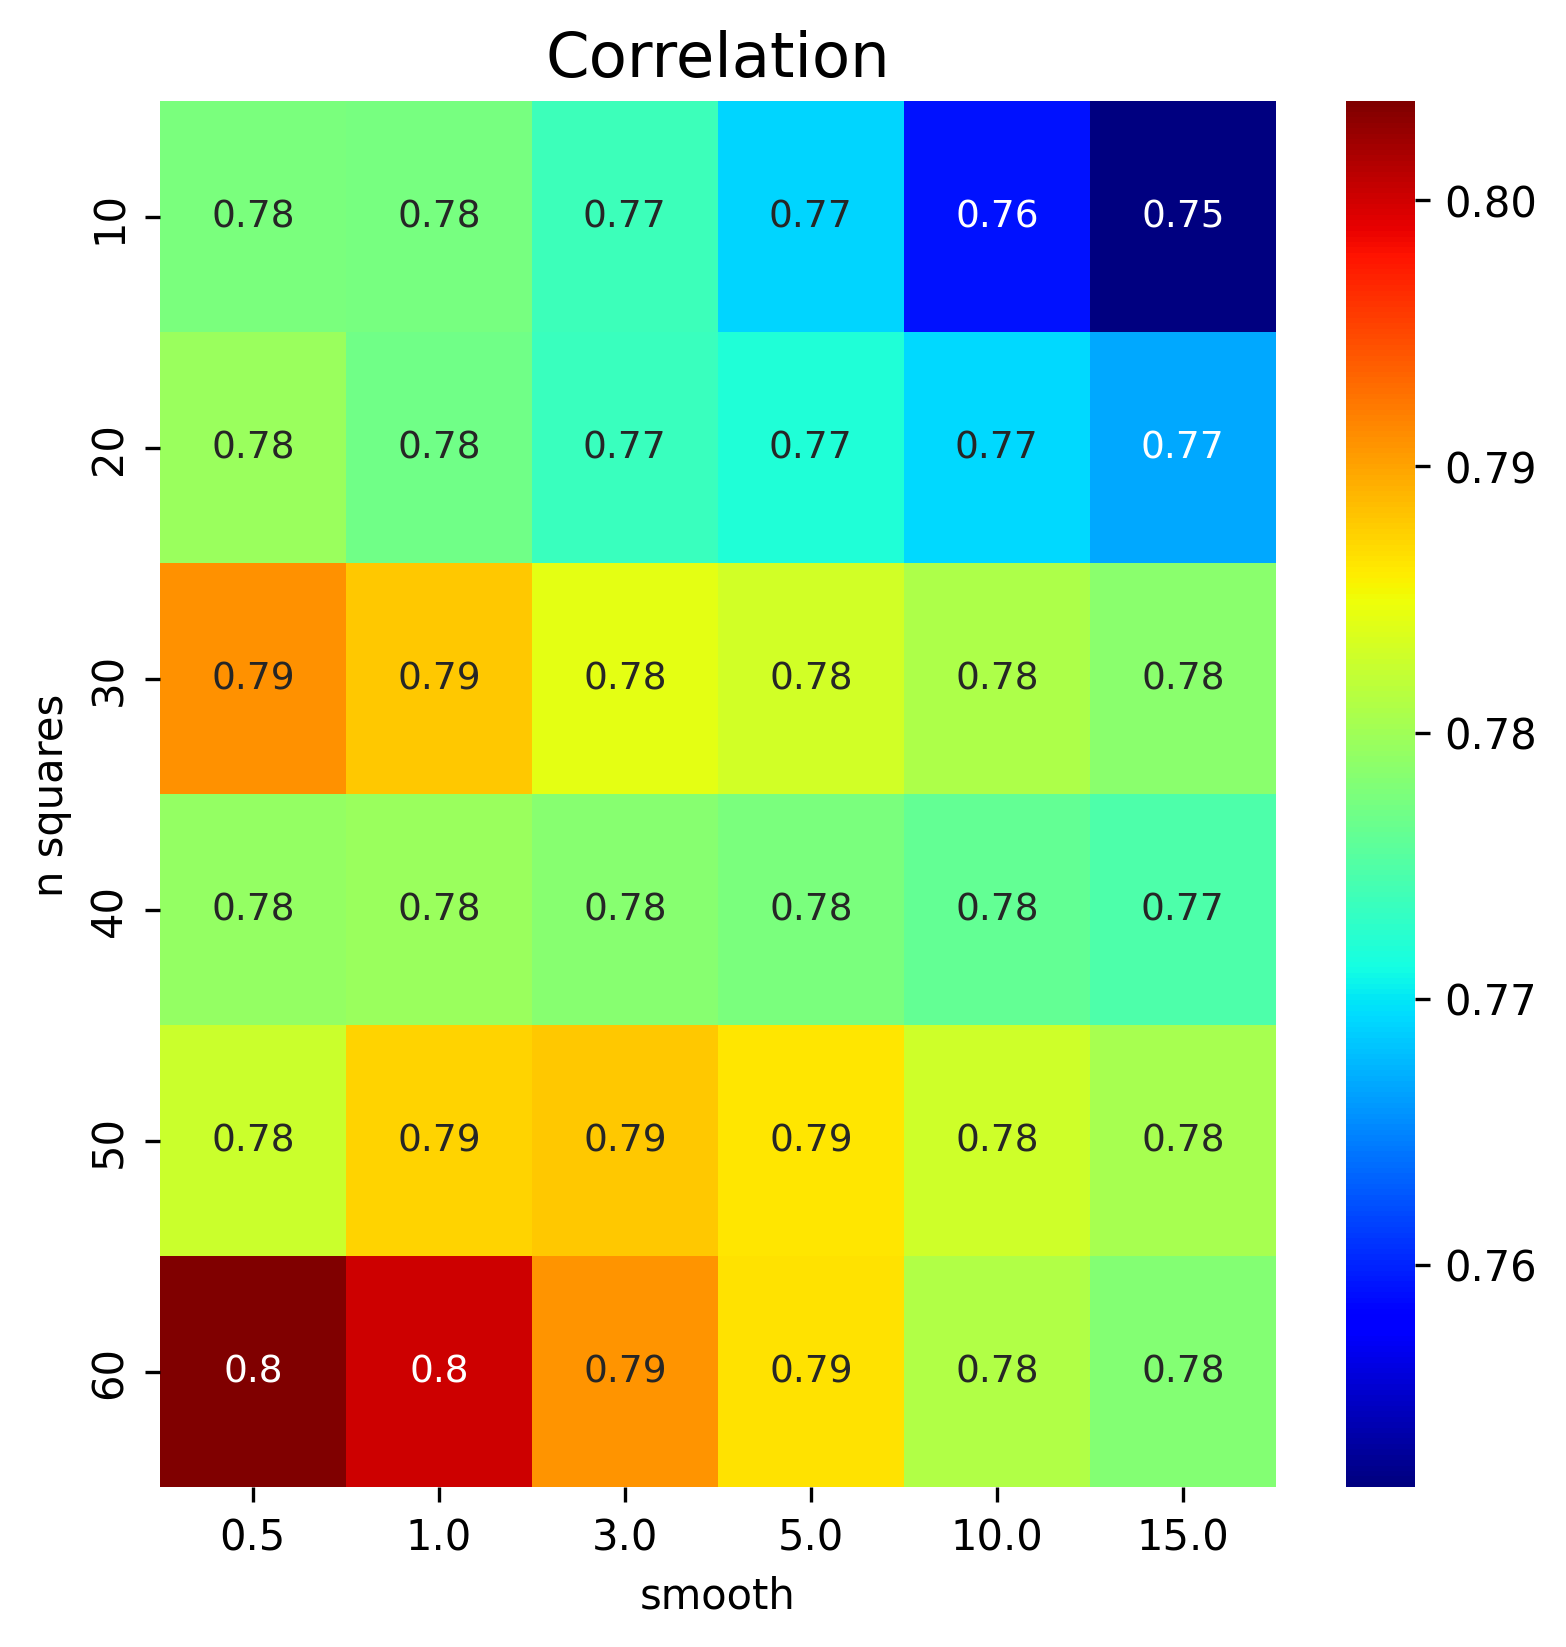

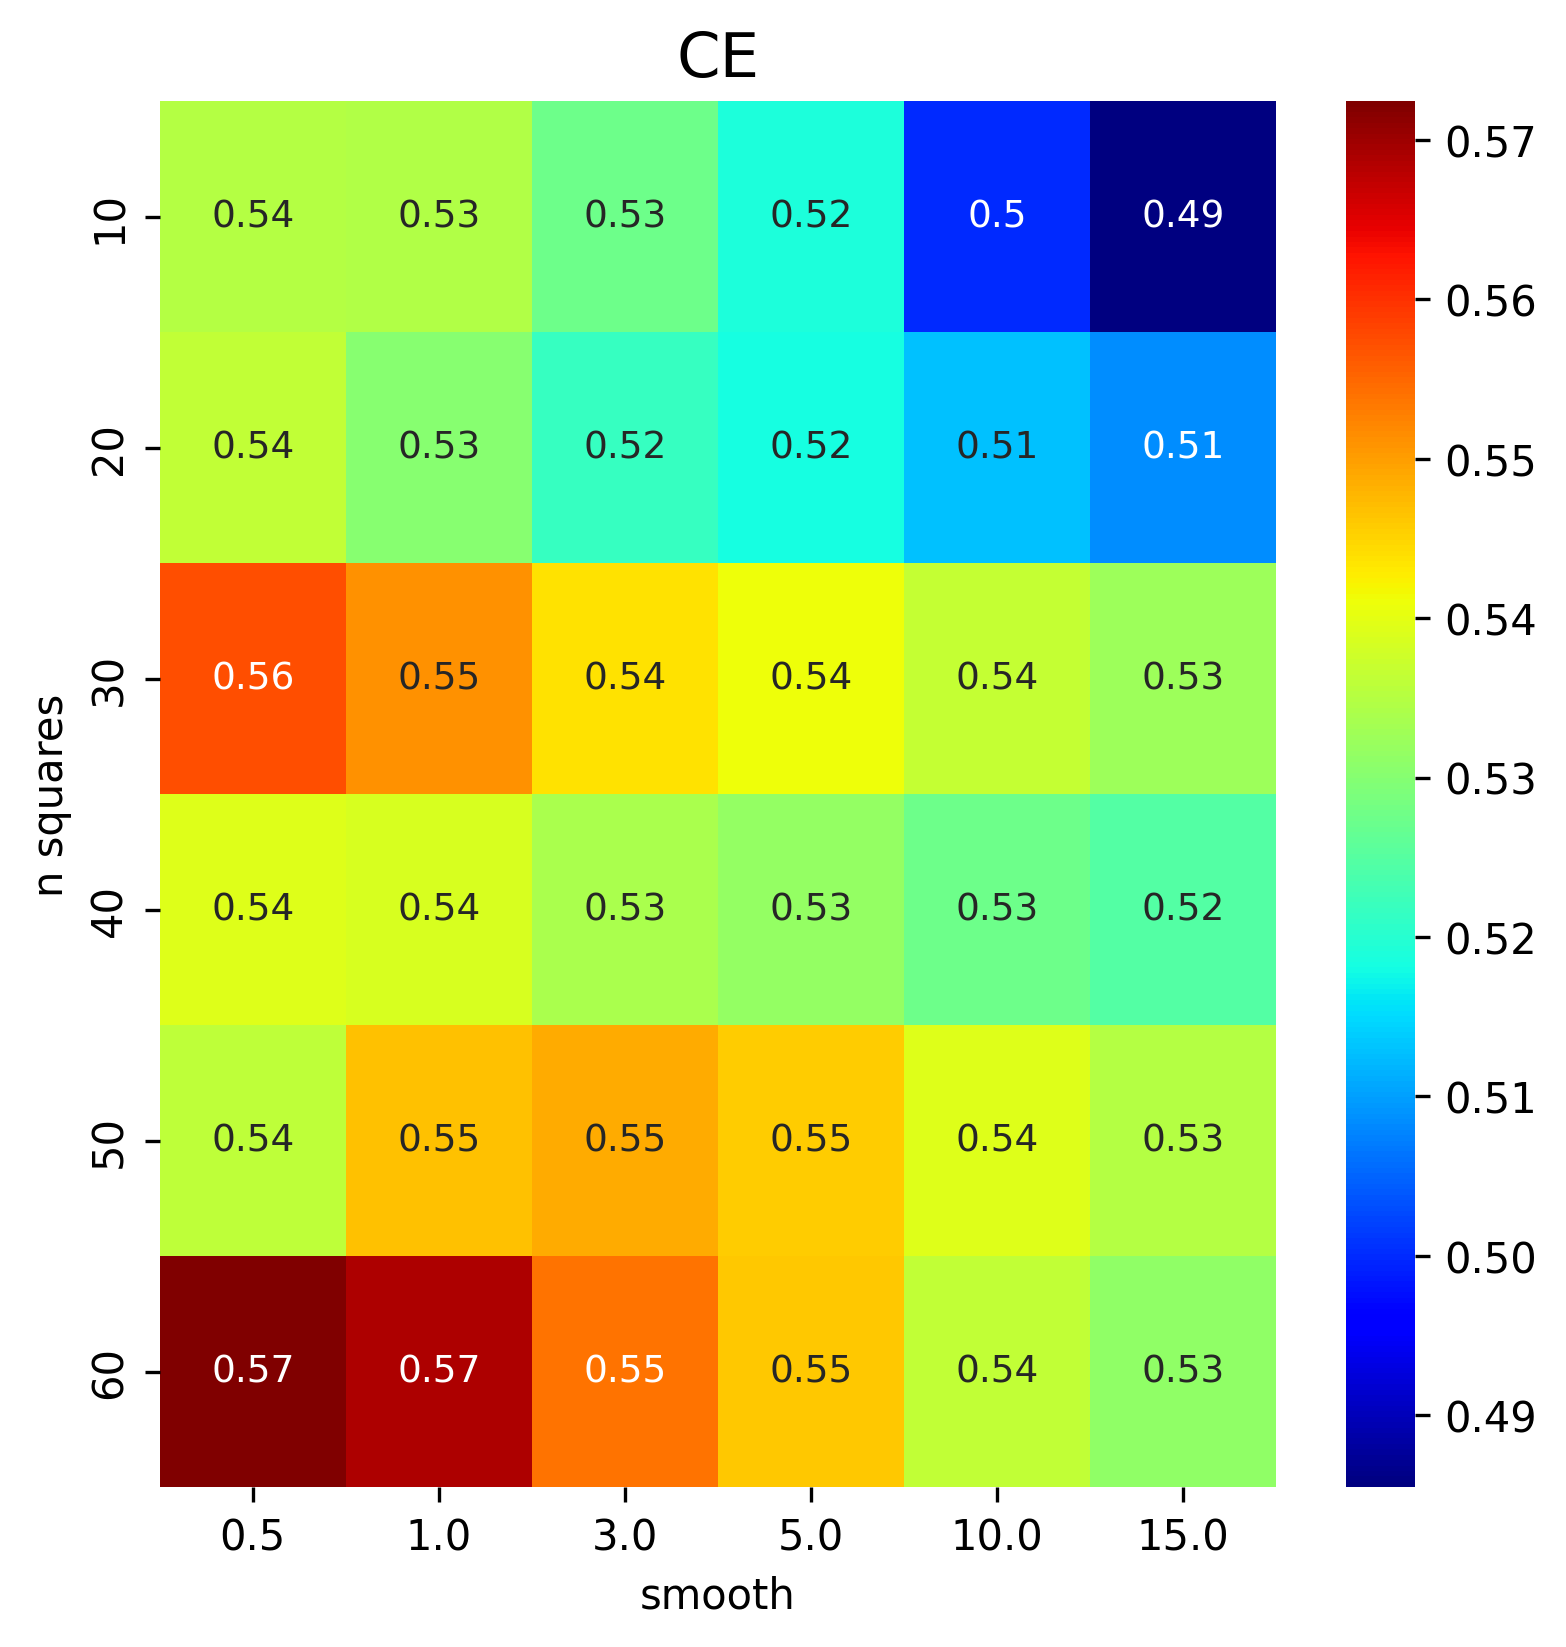

In [ ]:
tests_lko = leave_k_out_plot(train, clim_name, proxy_name,
                     k=20, n=100,
                     n_sq=[10,20,30,40,50,60], sm=[0.5,1,3,5,10,15],
                     kernel='thin_plate_spline', use_std = True, use_squares=True, Z_shift=True)

Find best parameters for surface (kernel='linear', Z_shift=False)

  0%|          | 0/6 [00:00<?, ?it/s]

smooth: 0.5



  0%|          | 0/6 [00:00<?, ?it/s]

n squares: 10



 17%|█▋        | 1/6 [01:04<05:20, 64.15s/it]

n squares: 20



 33%|███▎      | 2/6 [02:45<05:43, 85.81s/it]

n squares: 30



 50%|█████     | 3/6 [05:26<06:00, 120.22s/it]

n squares: 40



 67%|██████▋   | 4/6 [09:28<05:36, 168.19s/it]

n squares: 50



 83%|████████▎ | 5/6 [15:12<03:51, 231.75s/it]

n squares: 60



 17%|█▋        | 1/6 [23:00<1:55:04, 1380.81s/it]

smooth: 1



  0%|          | 0/6 [00:00<?, ?it/s]

n squares: 10



 17%|█▋        | 1/6 [01:03<05:18, 63.64s/it]

n squares: 20



 33%|███▎      | 2/6 [02:44<05:41, 85.27s/it]

n squares: 30



 50%|█████     | 3/6 [05:23<05:57, 119.28s/it]

n squares: 40



 67%|██████▋   | 4/6 [09:28<05:37, 168.97s/it]

n squares: 50



 83%|████████▎ | 5/6 [15:06<03:49, 229.73s/it]

n squares: 60



 33%|███▎      | 2/6 [45:50<1:31:36, 1374.21s/it]

smooth: 3



  0%|          | 0/6 [00:00<?, ?it/s]

n squares: 10



 17%|█▋        | 1/6 [01:04<05:21, 64.39s/it]

n squares: 20



 33%|███▎      | 2/6 [02:45<05:42, 85.70s/it]

n squares: 30



 50%|█████     | 3/6 [05:34<06:11, 123.91s/it]

n squares: 40



 67%|██████▋   | 4/6 [09:34<05:39, 169.97s/it]

n squares: 50



 83%|████████▎ | 5/6 [15:18<03:52, 232.63s/it]

n squares: 60



 50%|█████     | 3/6 [1:08:50<1:08:50, 1376.81s/it]

smooth: 5



  0%|          | 0/6 [00:00<?, ?it/s]

n squares: 10



 17%|█▋        | 1/6 [01:03<05:15, 63.13s/it]

n squares: 20



 33%|███▎      | 2/6 [02:43<05:40, 85.19s/it]

n squares: 30



 50%|█████     | 3/6 [05:27<06:03, 121.22s/it]

n squares: 40



 67%|██████▋   | 4/6 [09:28<05:36, 168.34s/it]

n squares: 50



 83%|████████▎ | 5/6 [15:10<03:51, 231.02s/it]

n squares: 60



 67%|██████▋   | 4/6 [1:31:42<45:49, 1374.96s/it]  

smooth: 10



  0%|          | 0/6 [00:00<?, ?it/s]

n squares: 10



 17%|█▋        | 1/6 [01:04<05:21, 64.25s/it]

n squares: 20



 33%|███▎      | 2/6 [02:45<05:43, 85.83s/it]

n squares: 30



 50%|█████     | 3/6 [05:25<05:59, 119.96s/it]

n squares: 40



 67%|██████▋   | 4/6 [09:27<05:36, 168.20s/it]

n squares: 50



 83%|████████▎ | 5/6 [15:09<03:50, 230.79s/it]

n squares: 60



 83%|████████▎ | 5/6 [1:54:32<22:53, 1373.37s/it]

smooth: 15



  0%|          | 0/6 [00:00<?, ?it/s]

n squares: 10



 17%|█▋        | 1/6 [01:05<05:26, 65.20s/it]

n squares: 20



 33%|███▎      | 2/6 [02:58<06:12, 93.21s/it]

n squares: 30



 50%|█████     | 3/6 [05:40<06:14, 124.98s/it]

n squares: 40



 67%|██████▋   | 4/6 [09:41<05:40, 170.50s/it]

n squares: 50



 83%|████████▎ | 5/6 [15:23<03:52, 232.61s/it]

n squares: 60



100%|██████████| 6/6 [2:17:50<00:00, 1378.44s/it]


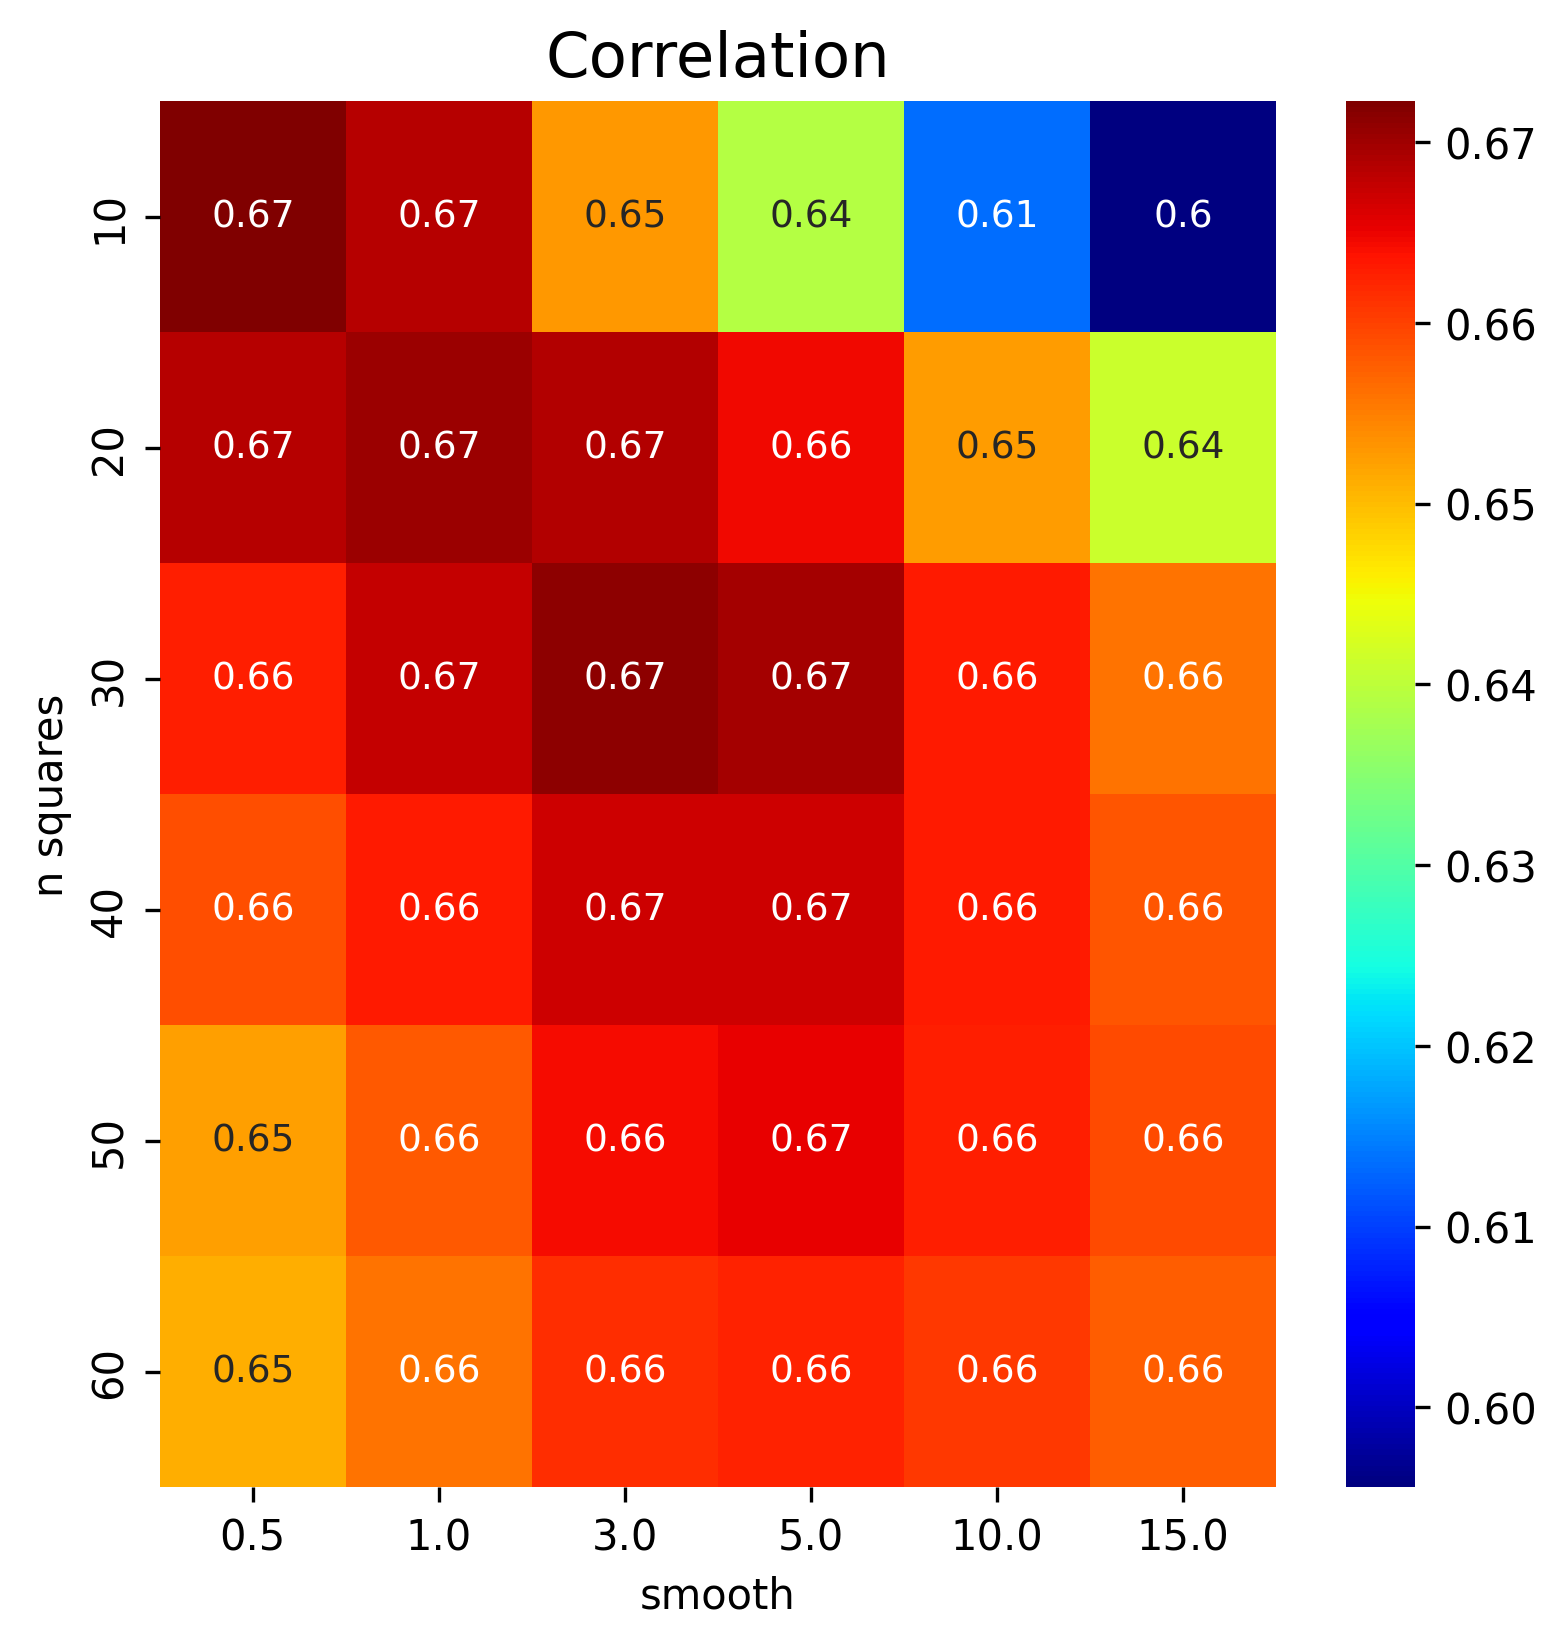

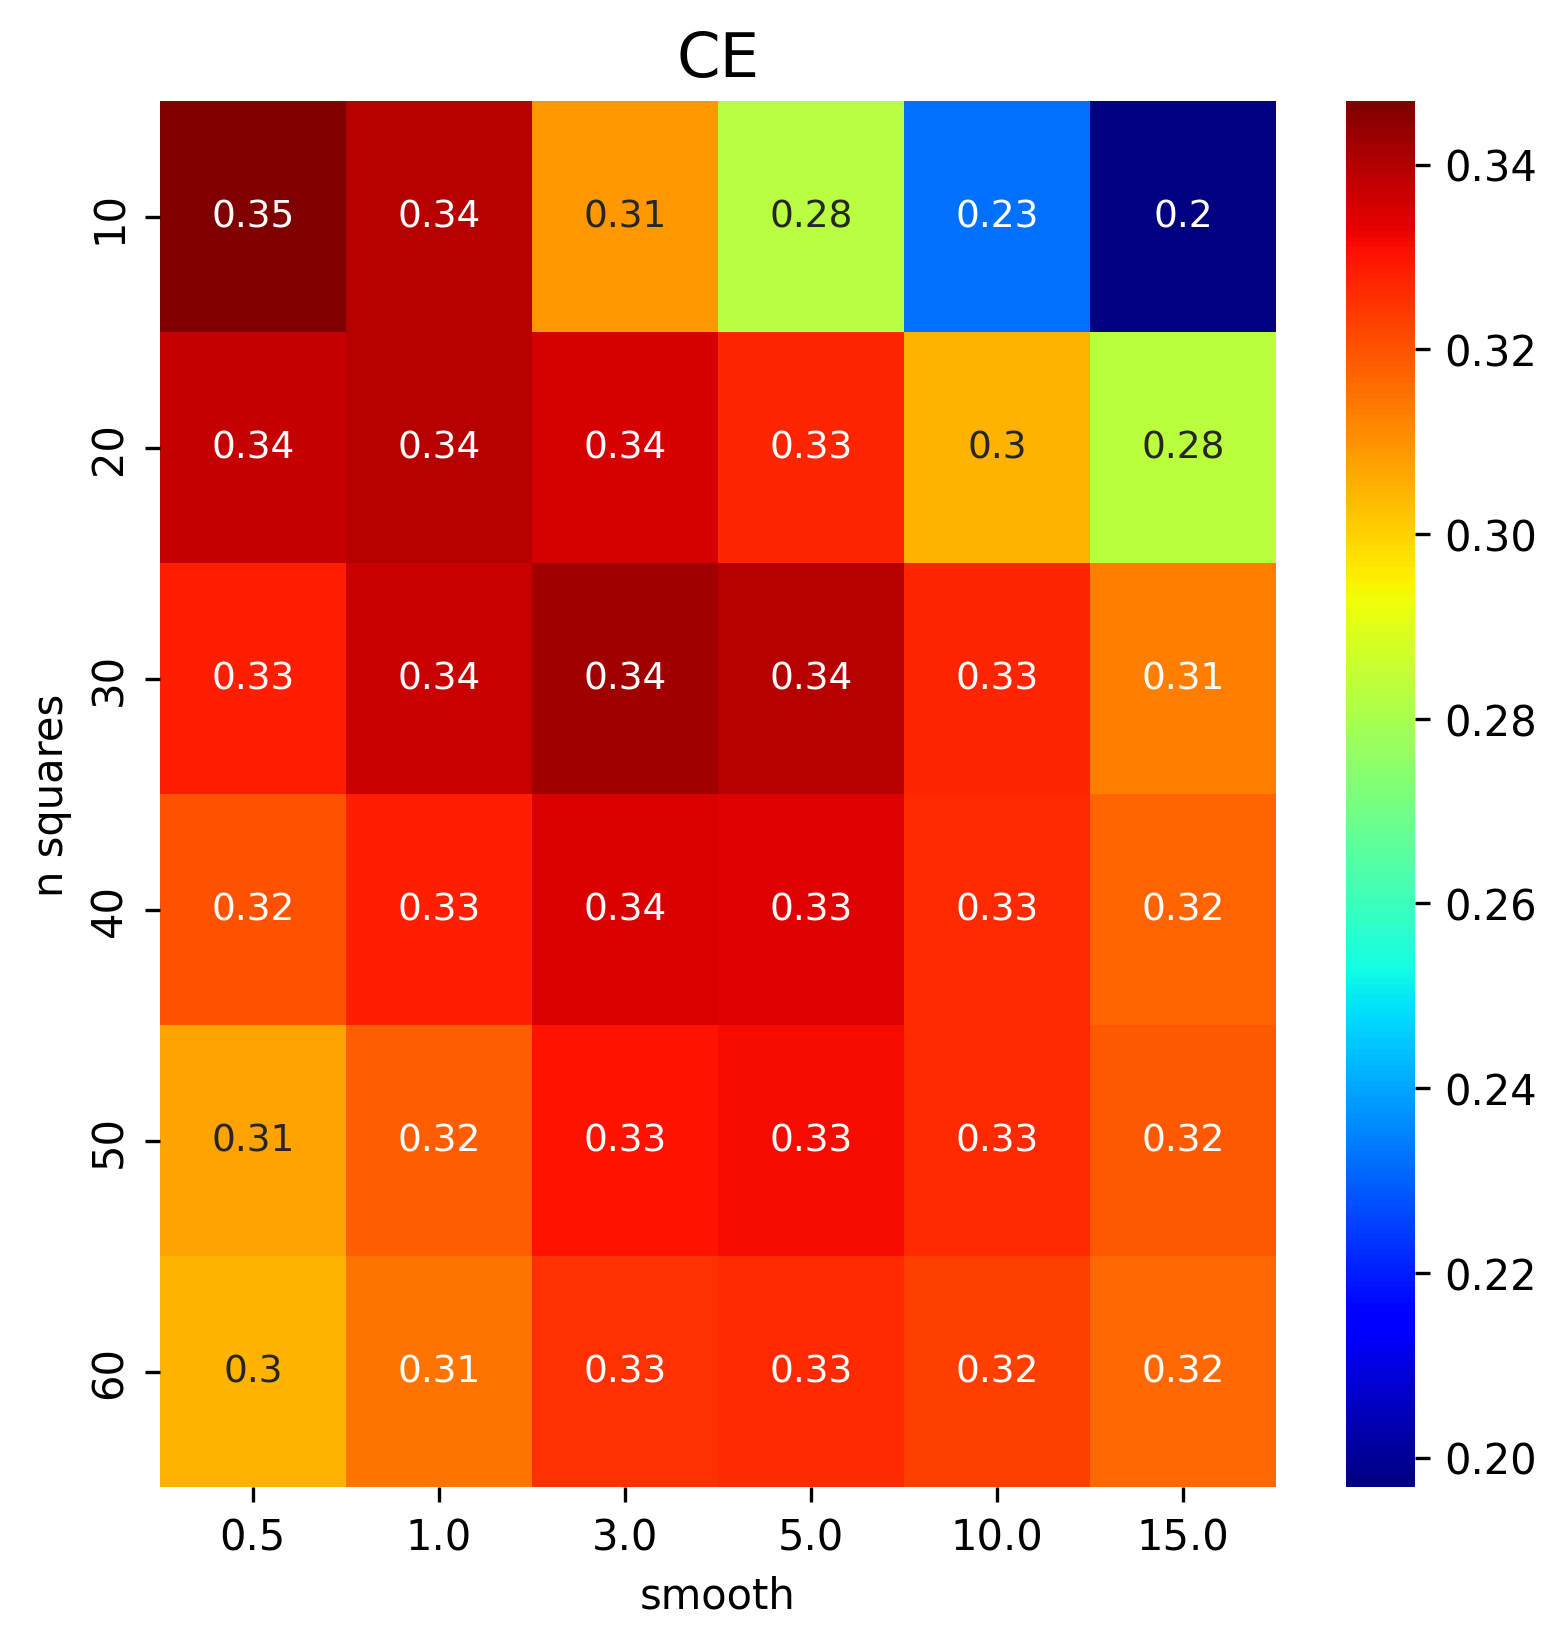

In [ ]:
tests_lko = leave_k_out_plot(train, clim_name, proxy_name,
                     k=20, n=100,
                     n_sq=[10,20,30,40,50,60], sm=[0.5,1,3,5,10,15],
                     kernel='linear', use_std = True, use_squares=True, Z_shift=False)

Find best parameters for surface (kernel='thin_plate_spline', Z_shift=True)

  0%|          | 0/6 [00:00<?, ?it/s]

smooth: 0.5



  0%|          | 0/6 [00:00<?, ?it/s]

n squares: 10



 17%|█▋        | 1/6 [01:10<05:50, 70.12s/it]

n squares: 20



 33%|███▎      | 2/6 [03:01<06:16, 94.23s/it]

n squares: 30



 50%|█████     | 3/6 [05:58<06:36, 132.12s/it]

n squares: 40



 67%|██████▋   | 4/6 [10:33<06:16, 188.46s/it]

n squares: 50



 83%|████████▎ | 5/6 [16:56<04:18, 258.84s/it]

n squares: 60



 17%|█▋        | 1/6 [25:38<2:08:11, 1538.24s/it]

smooth: 1



  0%|          | 0/6 [00:00<?, ?it/s]

n squares: 10



 17%|█▋        | 1/6 [01:07<05:36, 67.35s/it]

n squares: 20



 33%|███▎      | 2/6 [02:57<06:09, 92.42s/it]

n squares: 30



 50%|█████     | 3/6 [05:55<06:35, 131.78s/it]

n squares: 40



 67%|██████▋   | 4/6 [10:26<06:13, 186.50s/it]

n squares: 50



 83%|████████▎ | 5/6 [16:49<04:17, 257.28s/it]

n squares: 60



 33%|███▎      | 2/6 [51:03<1:42:01, 1530.49s/it]

smooth: 3



  0%|          | 0/6 [00:00<?, ?it/s]

n squares: 10



 17%|█▋        | 1/6 [01:07<05:36, 67.23s/it]

n squares: 20



 33%|███▎      | 2/6 [02:56<06:07, 91.85s/it]

n squares: 30



 50%|█████     | 3/6 [05:55<06:35, 131.71s/it]

n squares: 40



 67%|██████▋   | 4/6 [10:26<06:13, 186.64s/it]

n squares: 50



 83%|████████▎ | 5/6 [16:48<04:17, 257.02s/it]

n squares: 60



 50%|█████     | 3/6 [1:16:28<1:16:23, 1527.90s/it]

smooth: 5



  0%|          | 0/6 [00:00<?, ?it/s]

n squares: 10



 17%|█▋        | 1/6 [01:07<05:36, 67.26s/it]

n squares: 20



 33%|███▎      | 2/6 [02:58<06:12, 93.09s/it]

n squares: 30



 50%|█████     | 3/6 [05:56<06:35, 131.98s/it]

n squares: 40



 67%|██████▋   | 4/6 [10:28<06:14, 187.22s/it]

n squares: 50



 83%|████████▎ | 5/6 [16:48<04:16, 256.81s/it]

n squares: 60



 67%|██████▋   | 4/6 [1:41:53<50:53, 1526.73s/it]  

smooth: 10



  0%|          | 0/6 [00:00<?, ?it/s]

n squares: 10



 17%|█▋        | 1/6 [01:07<05:35, 67.15s/it]

n squares: 20



 33%|███▎      | 2/6 [02:56<06:08, 92.03s/it]

n squares: 30



 50%|█████     | 3/6 [05:56<06:36, 132.09s/it]

n squares: 40



 67%|██████▋   | 4/6 [10:27<06:13, 186.97s/it]

n squares: 50



 83%|████████▎ | 5/6 [16:48<04:16, 257.00s/it]

n squares: 60



 83%|████████▎ | 5/6 [2:07:13<25:24, 1524.50s/it]

smooth: 15



  0%|          | 0/6 [00:00<?, ?it/s]

n squares: 10



 17%|█▋        | 1/6 [01:06<05:32, 66.49s/it]

n squares: 20



 33%|███▎      | 2/6 [02:56<06:09, 92.36s/it]

n squares: 30



 50%|█████     | 3/6 [05:55<06:34, 131.48s/it]

n squares: 40



 67%|██████▋   | 4/6 [10:27<06:14, 187.03s/it]

n squares: 50



 83%|████████▎ | 5/6 [16:48<04:17, 257.23s/it]

n squares: 60



100%|██████████| 6/6 [2:32:39<00:00, 1526.60s/it]


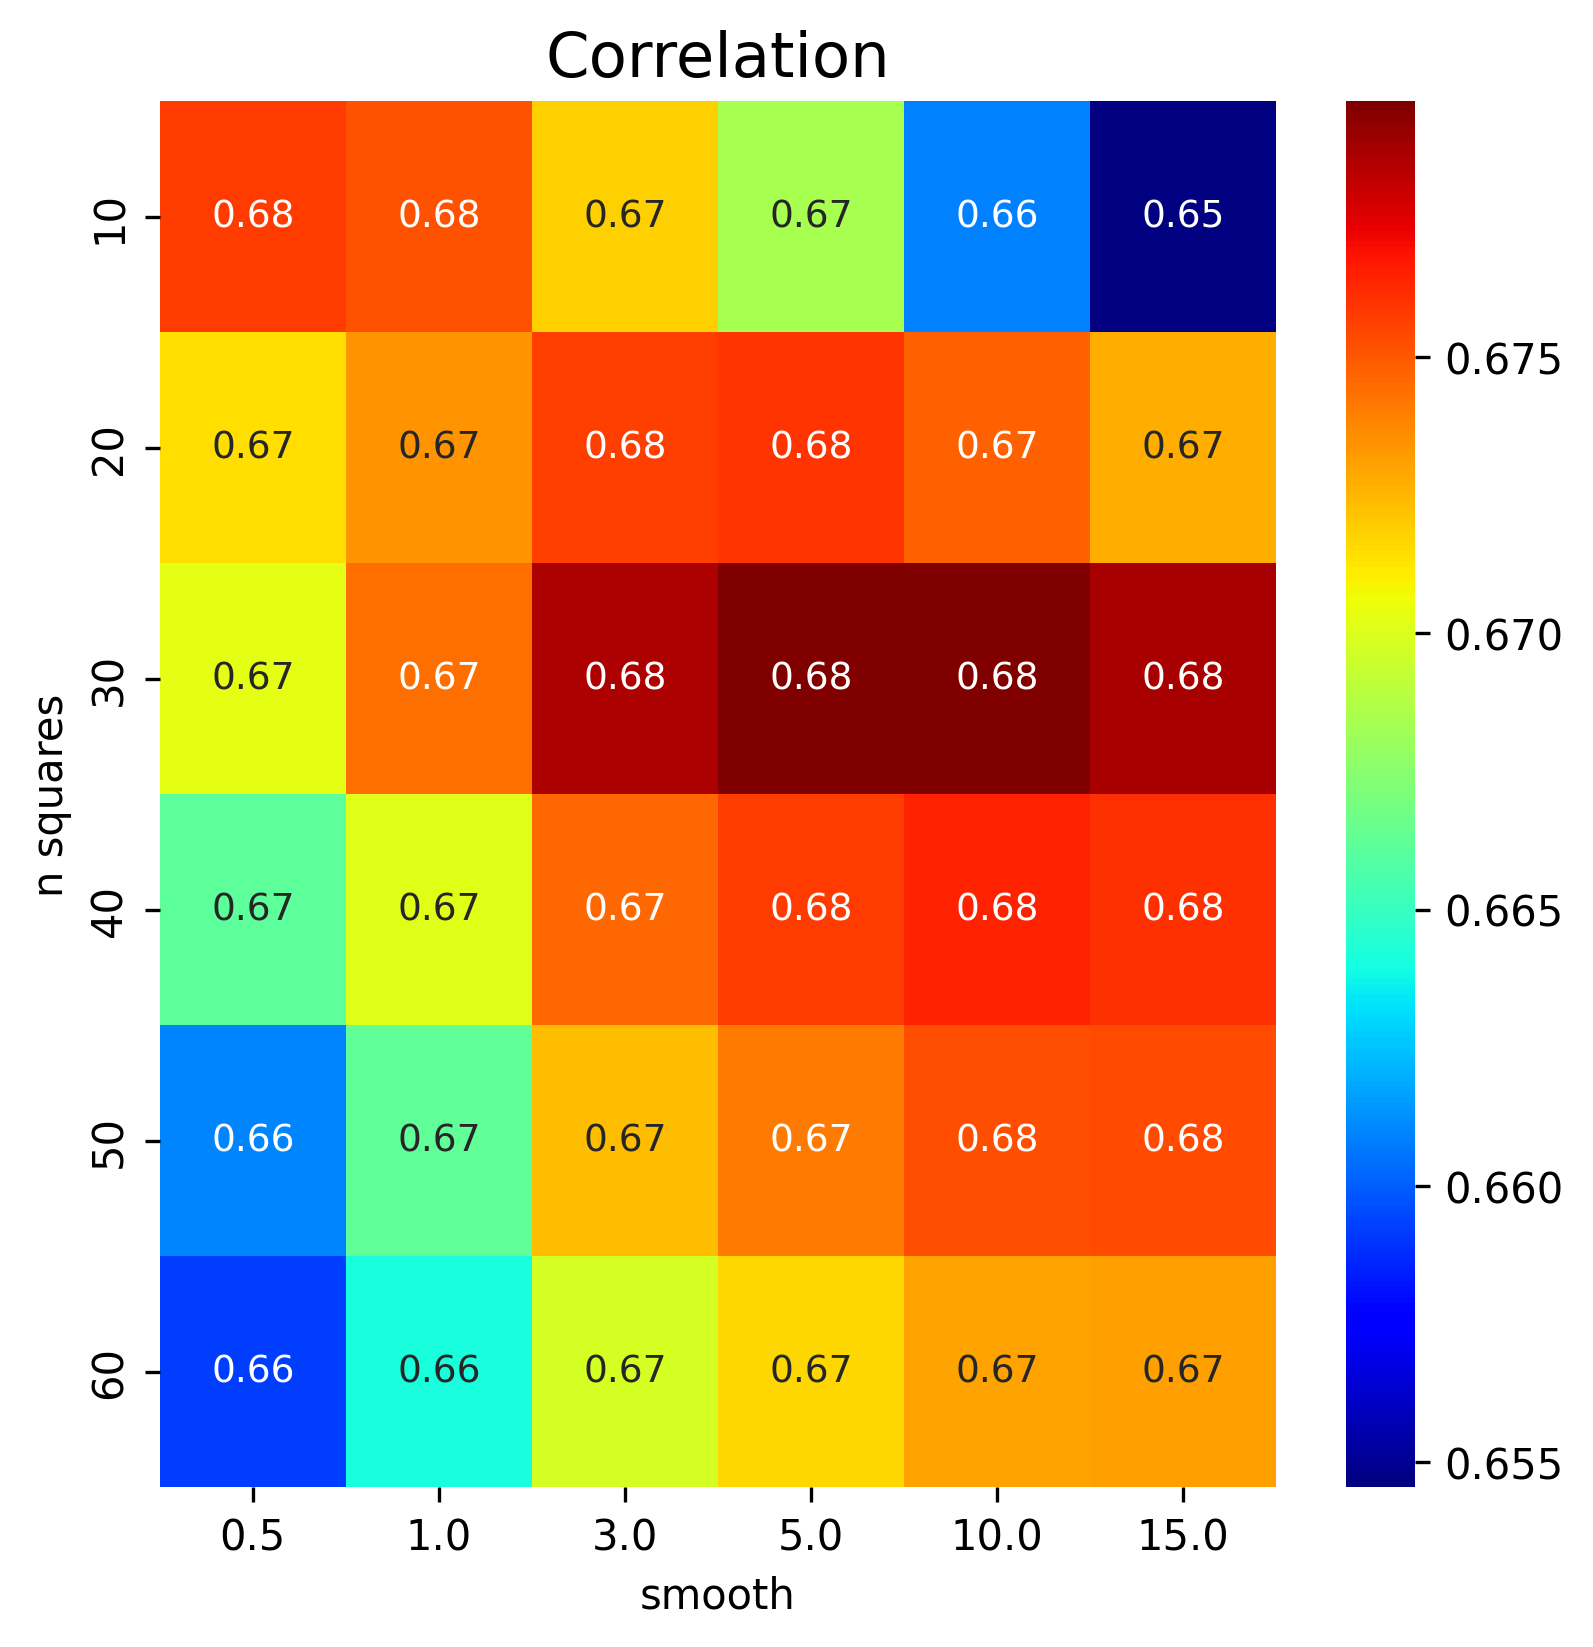

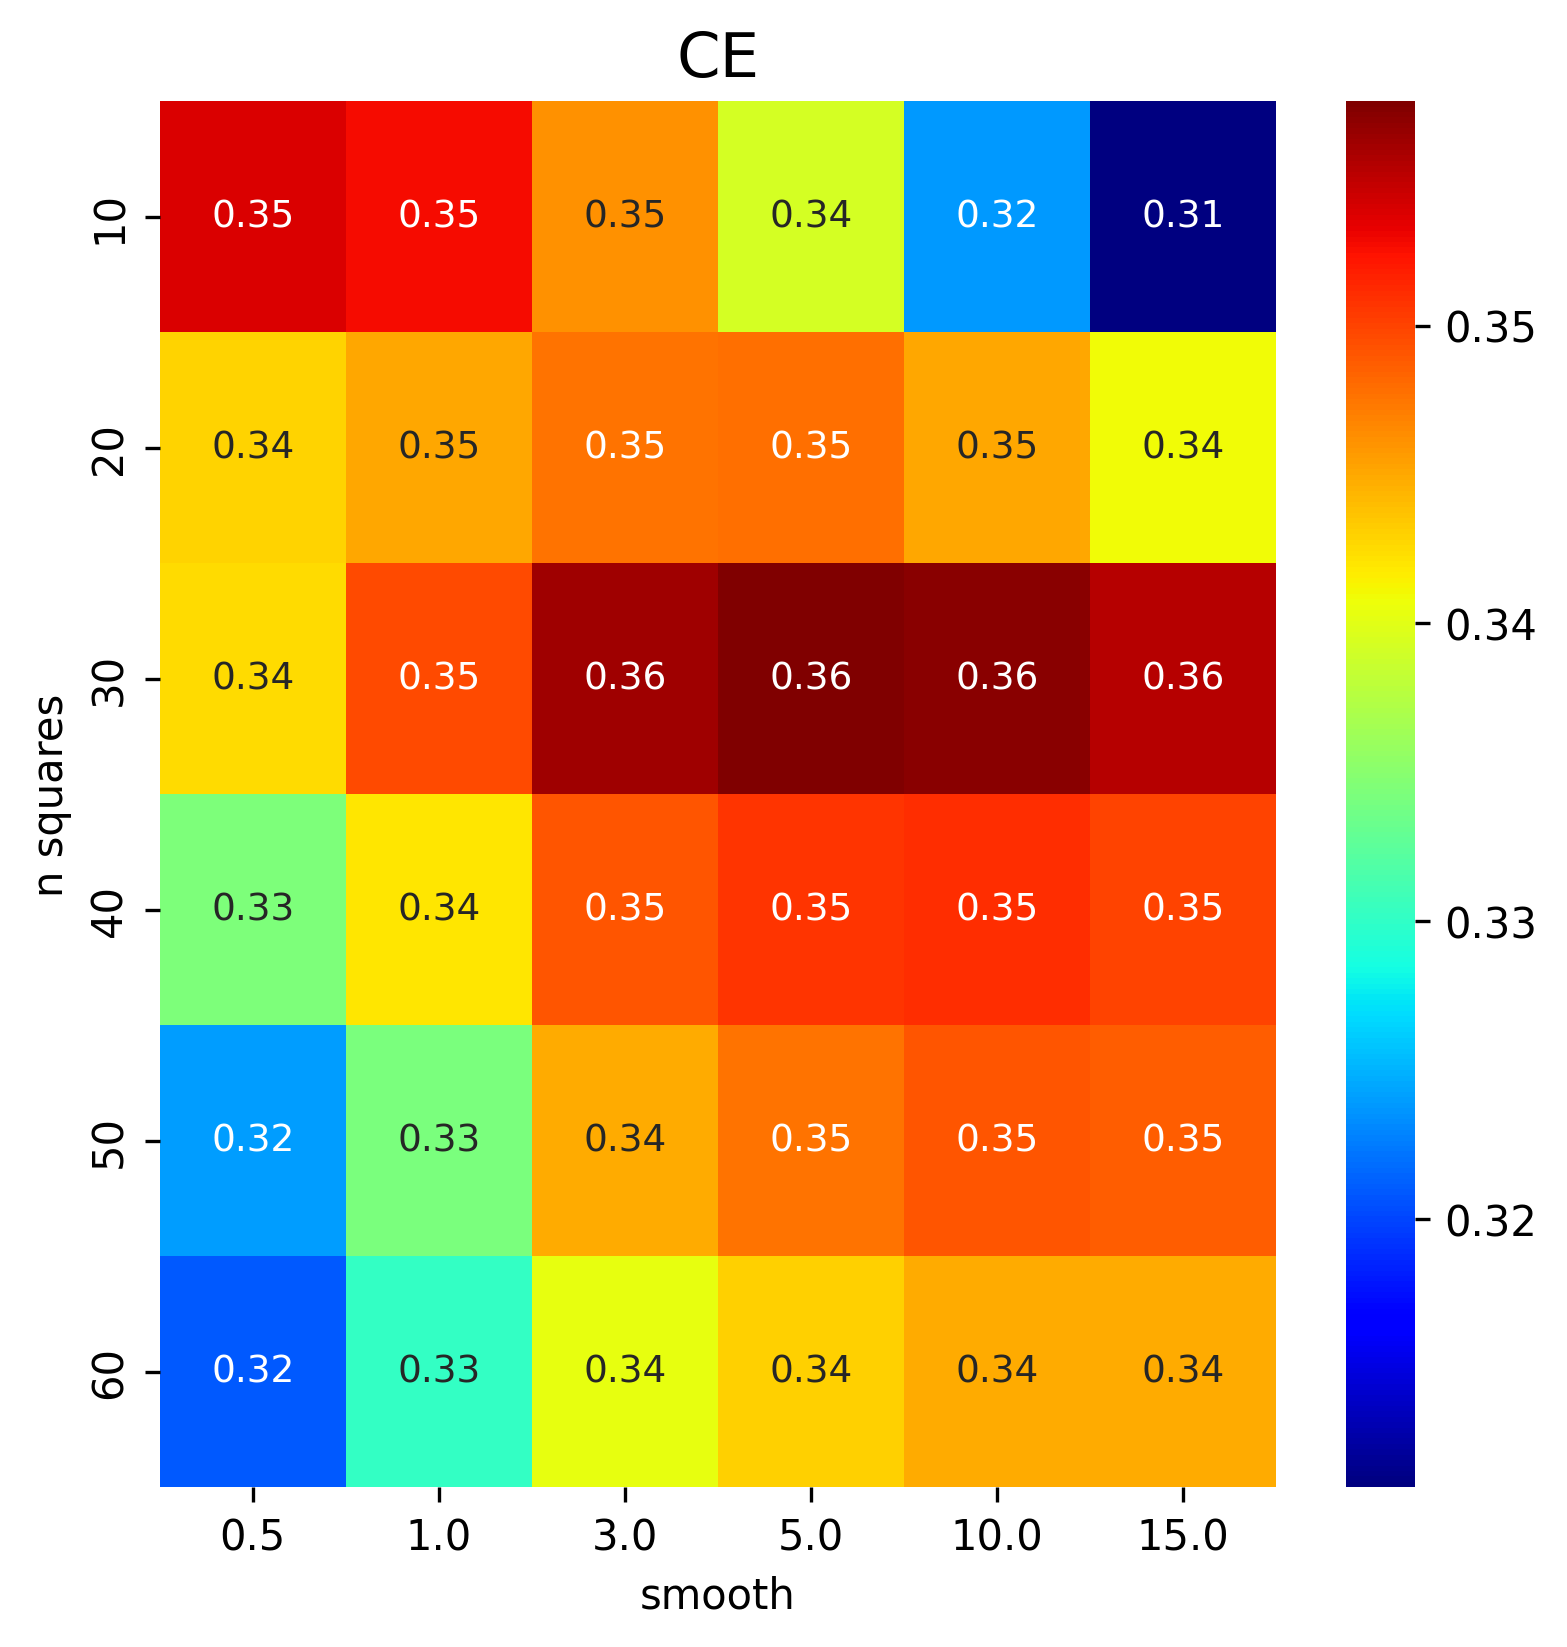

In [ ]:
tests_lko = leave_k_out_plot(train, clim_name, proxy_name,
                     k=20, n=100,
                     n_sq=[10,20,30,40,50,60], sm=[0.5,1,3,5,10,15],
                     kernel='thin_plate_spline', use_std = True, use_squares=True, Z_shift=False)

Distribution of predictor values

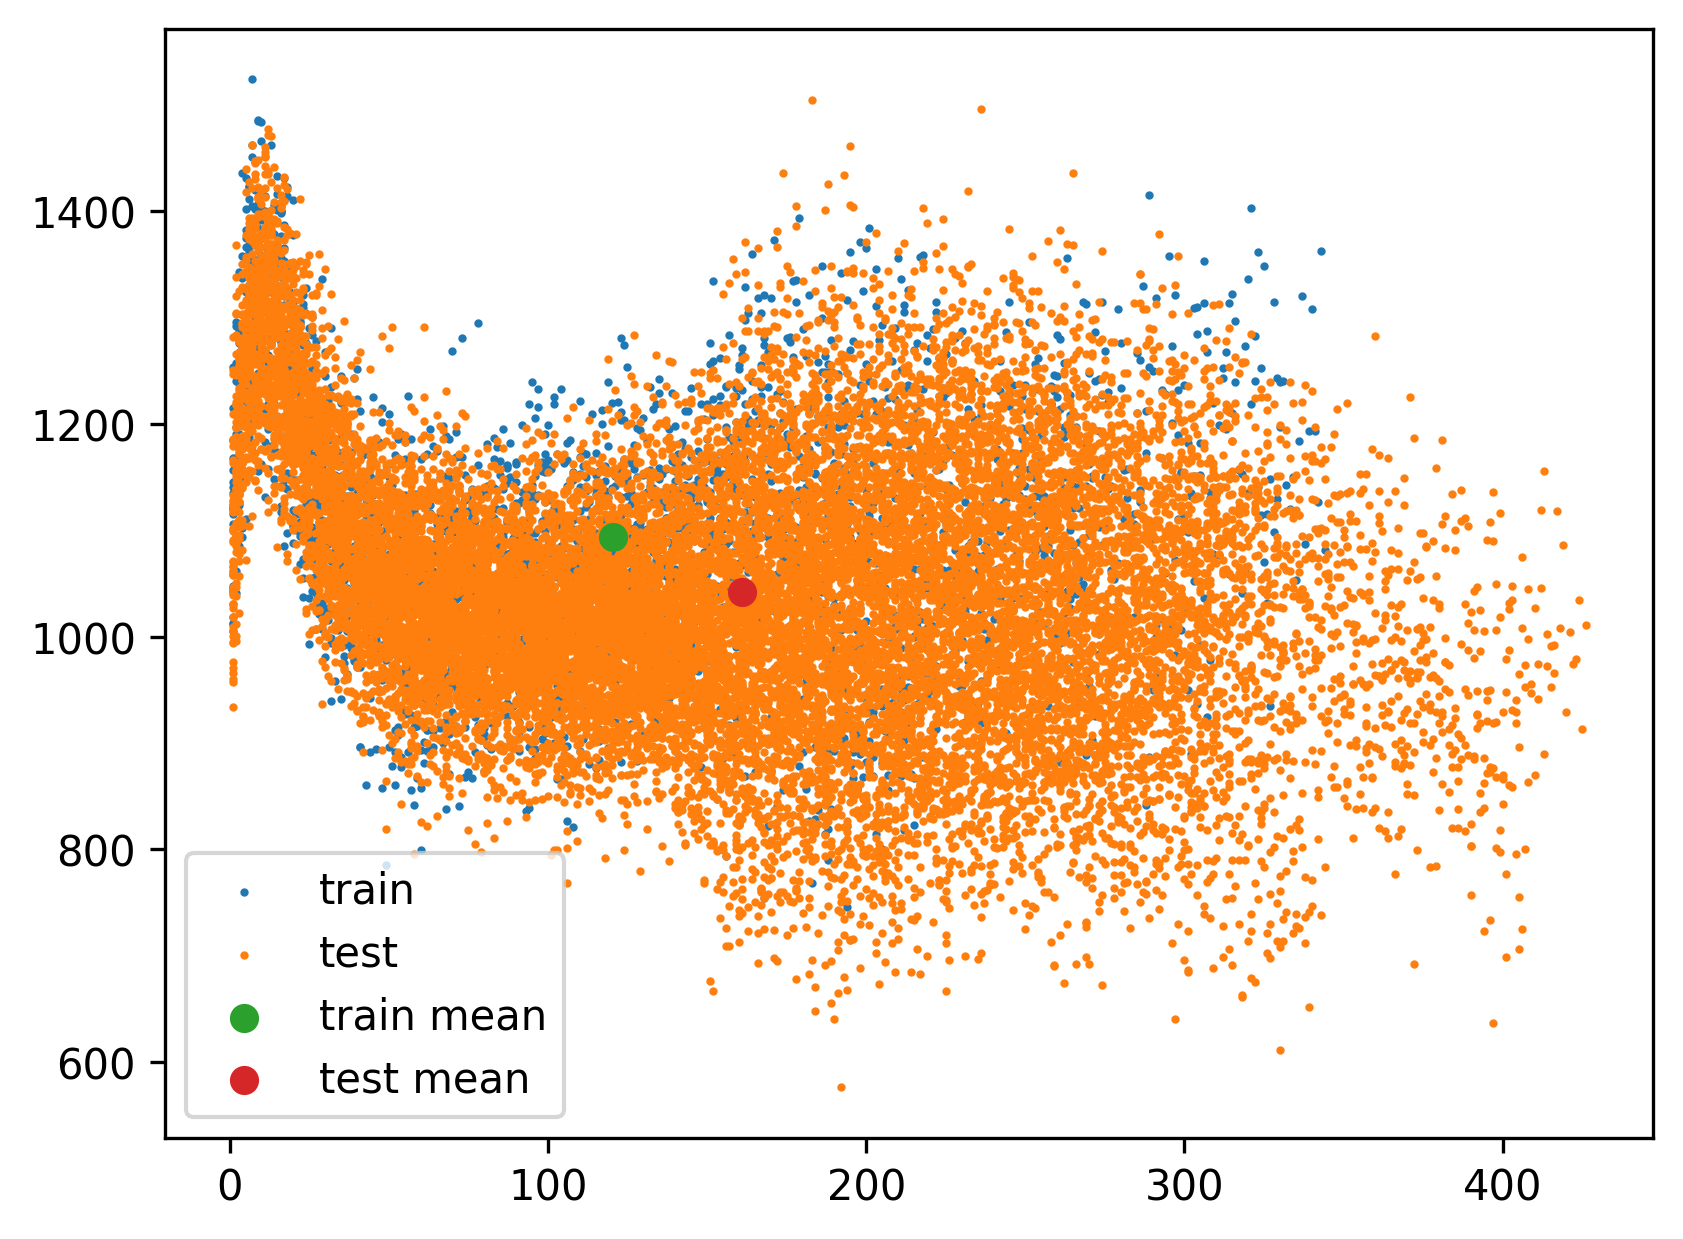

In [ ]:


s1 = plt.scatter(train.age, train.proxy,s=1)
s2 = plt.scatter(test.age, test.proxy,s=1)
s3 = plt.scatter(np.mean(train.age),np.mean(train.proxy))
s4 = plt.scatter(np.mean(test.age),np.mean(test.proxy))
plt.legend((s1,s2,s3,s4),('train','test','train mean','test mean'))

plt.show()

Surface construction and prediction

In [ ]:

sm = 0.5 #smoothing parameter
n_sq = 30 #number of squares in axes for averaging
n = 300 #number of values in axes
uncertainty_data_rep = {
  "part_s": 0.5,
  "n_iter": 1000,
  "alpha":0.05
}
uncertainty_instrumental = {
  "part_s": 0.5,
  "n_iter": 500,
  "alpha":0.05,
  'kernel':'linear',
  'use_squares':True,
  'n' : 300,
  'n_sq' : 50,
  'sm' : 0.5
}

test_p_train = pd.concat([test,train])

proxy_lim = [min(test_p_train[proxy_name]), max(test_p_train[proxy_name])]
age_lim = [min(test_p_train['age']), max(test_p_train['age'])]

surface = make_surface(train, train_dict, sm, n_sq, n,
                              proxy_lim = proxy_lim,
                              age_lim = age_lim,
                              kernel='linear',
                              proxy_name=proxy_name,
                              clim_var = clim_name,
                       use_squares=True)


#test_lim = test.loc[(test['proxy'].values>proxy_lim_train[0]) & (test['proxy'].values<proxy_lim_train[1]),:]
pred_df = predict_on_surface(surface, train_dict, train, test,
           use_std=True,
           proxy_name=proxy_name,
           clim_var = clim_name,
            proxy_lim = proxy_lim,
            age_lim = age_lim,
           uncertainty_data_rep = None,
           uncertainty_instrumental = uncertainty_instrumental)

nn = 'smooth = ' + str(sm)
plot2d(train, surface, name_ = nn, proxy_name=proxy_name, clim_name=clim_name)
plot3d(train, surface, proxy_lim, age_lim, name_ = '', proxy_name=proxy_name, clim_name=clim_name)


Output hidden; open in https://colab.research.google.com to view.

direct corr: 0.9774135308198935
direct_RE 0.9680269201831234
direct CE:  0.9434284442032556
RCS corr: 0.9696862398904499
RCS RE 0.9418557318486207
RCS CE:  0.8971224627459754
RCS-sf corr: 0.9692907140453012
RCS-sf RE 0.9132533394581103
RCS-sf CE:  0.8465148313789761


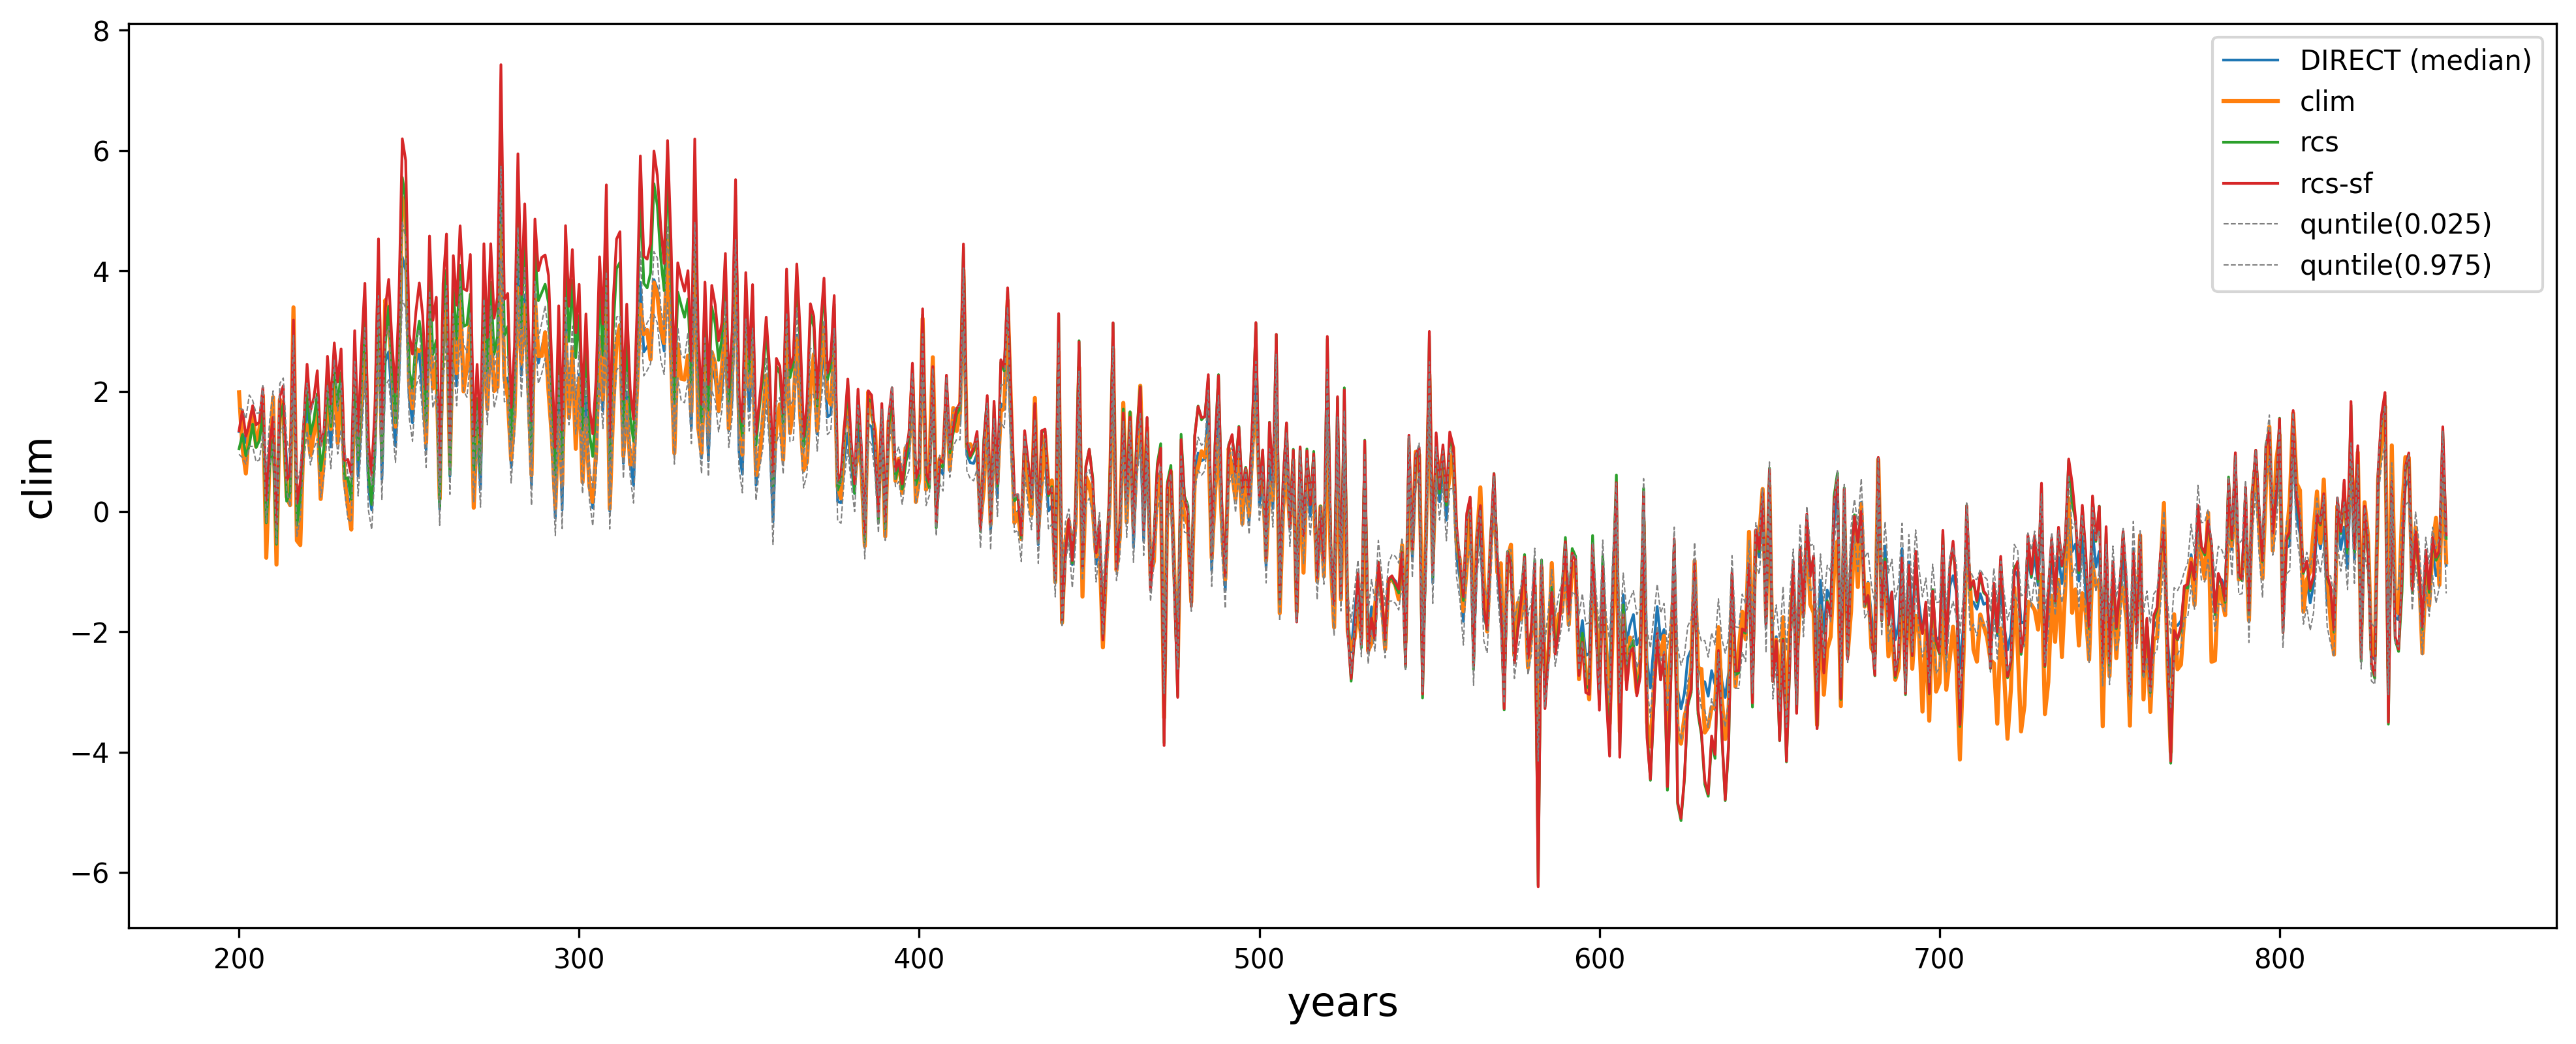

In [ ]:


from sklearn.linear_model import LinearRegression
X = train.rcs_crn.values.reshape(-1, 1)
y = train.clim.values
reg = LinearRegression().fit(X, y)
preds_rcs = reg.predict(pred_df.rcs_crn.values.reshape(-1, 1))

X_sf = train.rcs_sf_crn.values.reshape(-1, 1)
y_sf = train.clim.values
reg_sf = LinearRegression().fit(X_sf, y_sf)
preds_rcs_sf = reg_sf.predict(pred_df.rcs_sf_crn.values.reshape(-1, 1))




import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))

plt.plot(pred_df.years, pred_df['median'].values, label = "DIRECT (median)",lw=1)
plt.plot(pred_df.years, pred_df['clim'].values, label = "clim")
plt.plot(pred_df.years, preds_rcs, label = "rcs",lw=1)
plt.plot(pred_df.years, preds_rcs_sf, label = "rcs-sf",lw=1)
plt.plot(pred_df.years, pred_df['lower_2'].values, c='gray',lw=0.5,linestyle='dashed',label = "quntile(0.025)")
plt.plot(pred_df.years, pred_df['upper_2'].values, c='gray',lw=0.5,linestyle='dashed', label = "quntile(0.975)")
plt.ylabel('clim',fontsize=15)
plt.xlabel('years',fontsize=15)
plt.legend()


print('direct corr: ' + str(np.corrcoef(pred_df['median'].values, pred_df['clim'].values)[0][1]))
print('direct_RE', RE(pred_df['clim'].values,pred_df['median'].values,train_dict['train_mean_mean']))
print('direct CE: ', CE(pred_df['clim'].values,pred_df['median'].values))


print('RCS corr: ' + str(np.corrcoef(preds_rcs, pred_df['clim'].values)[0][1]))
print('RCS RE', RE(pred_df['clim'].values,preds_rcs,train_dict['train_mean_mean']))
print('RCS CE: ', CE(pred_df['clim'].values,preds_rcs))

print('RCS-sf corr: ' + str(np.corrcoef(preds_rcs_sf, pred_df['clim'].values)[0][1]))
print('RCS-sf RE', RE(pred_df['clim'].values,preds_rcs_sf,train_dict['train_mean_mean']))
print('RCS-sf CE: ', CE(pred_df['clim'].values,preds_rcs_sf))